# Sentiment based Product Recommendation System

## Importing the needed libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

#general modules
from collections import Counter
from datetime import datetime
import itertools
import time

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, make_scorer
from sklearn.model_selection import StratifiedKFold

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer

# SMOTE
from imblearn.over_sampling import SMOTE

# Transformation and pipelines
from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline as imblearn_make_pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

#Recommendation System
from sklearn.metrics.pairwise import pairwise_distances

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aadit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aadit\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aadit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option("max_colwidth", 500)

## EDA and Data cleaning

In [3]:
df = pd.read_csv("sample30.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [5]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensatio...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


In [6]:
df[pd.isnull(df['user_sentiment'])]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & TV,Disney,Blu-ray,Children & Family,Movies & Music,Movies & TV Shows,Electronics, Tech Toys, Movies, Music,Blu-Rays,See ALL Blu-Ray,Frys",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),2014-11-07T00:00:00.000Z,NaN,True,5,my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy,a super hit with my children. they loved it!!??,NaN,mamad,7.87E+11,NaN


In [7]:
df[pd.isnull(df['manufacturer'])]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
22210,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Instawatch Movies,Movies, Music & Books,Movies,Action & Adventure,Movies & TV,Shop Instawatch,Movies & Music",NaN,Alex Cross (dvdvideo),2013-03-05T00:00:00.000Z,NaN,False,1,"I have read the entire Alex Cross series and I was so disappointed in the movie. Perry was good as Alex Cross, but how can Alex not have his life long friend Samson in the movie? And Cicely Tyson as Nana momma? She was a great actress in her day, but her slurred speech for Nana the retired demanding school teacher was a poor cast. I'm sorry I bought the movie. They need to do another movie and stay closer to the books.",Disappointing casting,NaN,NaN,poorcrossing,Negative
22211,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Instawatch Movies,Movies, Music & Books,Movies,Action & Adventure,Movies & TV,Shop Instawatch,Movies & Music",NaN,Alex Cross (dvdvideo),2013-10-11T00:00:00.000Z,NaN,False,1,"Idris Elba was originally cast in the lead role. Apparently before the budget was cut dramatically. Had they stuck with that decision, this film could have been a great deal better. As it is, Tyler Perry is awful as the lead. Every scene with him speaking made me cringe. I knew this movie was a throw away when I read a producer's quote (after switching from Idris to Tyler) that said, ""if you can get Will Smith or Tyler Perry, you do it""... Like Perry is in the same league as Will Smith when ...",Atrocious casting,NaN,NaN,naberios,Positive
22212,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Instawatch Movies,Movies, Music & Books,Movies,Action & Adventure,Movies & TV,Shop Instawatch,Movies & Music",NaN,Alex Cross (dvdvideo),2017-06-11T00:00:00.000Z,NaN,False,2,I was way more excited or this movie than I should have been. Bummer,Meh,NaN,NaN,jz30,Positive
22213,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Instawatch Movies,Movies, Music & Books,Movies,Action & Adventure,Movies & TV,Shop Instawatch,Movies & Music",NaN,Alex Cross (dvdvideo),2014-12-27T00:00:00.000Z,NaN,False,2,"I'm a huge fan of James Patterson and although few movies are as good as the book, this one was a disappointment to me. I'm not feeling the casting of Tyler Perry as Alex Cross. Ok movie to watch on a rainy day.",Disappointing Movie,NaN,NaN,david,Positive
22214,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Instawatch Movies,Movies, Music & Books,Movies,Action & Adventure,Movies & TV,Shop Instawatch,Movies & Music",NaN,Alex Cross (dvdvideo),2015-12-26T20:30:31.000Z,NaN,True,3,"not as exciting as the book, but very good",Alex Cross Dvd,NaN,NaN,bobc,Positive
22215,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Instawatch Movies,Movies, Music & Books,Movies,Action & Adventure,Movies & TV,Shop Instawatch,Movies & Music",NaN,Alex Cross (dvdvideo),2014-11-15T00:00:00.000Z,NaN,False,3,If you are a fan of Tyler Perry and his Madea series then you can probably stomach sitting through this 90 min snore fest. Otherwise save yourself the trouble and read the book...hopefully Perry won't turn this into one of his stage plays,Alex Cross aka Madea gets a gun,NaN,NaN,optimalprimus,Negative
22216,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Instawatch Movies,Movies, Music & Books,Movies,Action & Adventure,Movies & TV,Shop Instawatch,Movies & Music",NaN,Alex Cross (dvdvideo),2014-01-06T00:00:00.000Z,NaN,True,3,"I thought the story was OK and the action was good. After seeing Morgan Freeman as Alex Cross, it was hard to accept Tyler Perry in this role.",Not a big fan of Tyler Perry.,

In [8]:
df[pd.isnull(df['reviews_didPurchase'])]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
30,AV1d76w7vKc47QAVhCqn,J.R. Watkins,"Personal Care,Skin Care,Hand Cream,Beauty,Body Lotions & Creams,Natural Beauty,Natural Personal Care,Natural Skin Care,Ways To Shop,Bath & Body,Hand Creams & Lotions",J.R. Watkins,"J.R. Watkins Hand Cream, Lemon Cream",2011-01-30T00:55:26.000Z,NaN,NaN,5,"yes, the scent is the best. if you like lemon frosting you won't be able to get enough of this lotion. but also, it's almost 100 natural, none of the yucky ingredients like in major brands of lotion. no mineral oil, no petroleum, etc. but also, it completely works. you know how sometimes you opt for organic choices and it's good, but not as good as popular but nastier brands jr watkins delivers. this lotion softens your hands and body, leaves you ungreasy and smells perfect. even my fiance l...",Yummilicious And...,NaN,NaN,peach pie,Positive
37,AV1h6gSl-jtxr-f31p40,AMBI,"Personal Care,Bath, Shower & Soap,Featured Brands,Health & Beauty,Johnson & Johnson,Bath & Body,Body Wash & Cleansers,Beauty,Skin Care,Facial Cleansers,Soaps",FLEMING & CO,Ambi Complexion Cleansing Bar,2016-02-28T05:15:56.000Z,NaN,True,5,Makes my skin feel clean and not super dry where its ashy if i dont follow with a moisturiser as soon as im done. The skin doesnt feel oily or tacky. Makes my skin more radiant and use of foundation and concealer is not needed to make the skin look even and hydrated.,Still Works,NaN,NaN,shedove,Positive
43,AV1h6Gu0glJLPUi8IjA_,Johnson's,"Personal Care,Baby Care,Baby Bubble Bath,Baby,Bath & Potty,Toiletries,Bubble Bath,Baby Bath,Bath & Body,Body Wash & Cleansers",Johnson's,"Johnson's Baby Bubble Bath and Wash, 15oz",2017-05-09T07:36:44.000Z,NaN,True,4,"Well, Johnson's need I say more I know, right. Ok, but I will. I have used Johnson's since I was a baby, yes it's been a long time. But let's get to the Chase, it's 2 in 1. Come on, who doesn't like 2 in 1 It's hard enough to get the little loves clean, so any help is always a blessing... So, Johnson's Bubble Bath and wash is a must have in this house!!!",2 In 1!!!,Rohnert Park,NaN,solo,Positive
67,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face Moisturizers,Facial Moisturizers,Moisturizers,Creams & Moisturizers",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T03:08:38.000Z,NaN,True,3,"Today is my first time using this product. Felt great going on immediately, felt moisturized without being too greasy. Although it smells great I would have loved to have this formula in a fragrance-free option, my skin tends to be a little sensitive to fragrances, but I will give a final review in a couple of weeks",Why No Fragrance-Free Formula,Brooklyn,NaN,mylifeinheels,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29681,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday Shop,Christmas,Featured Brands,Health & Beauty,L'oreal,Personal Care,Hair Treatments,Conditioner",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,2017-01-20T21:50:36.000Z,NaN,True,5,"While I did not find the pre-wash clay mask very useful, I loved the shampoo and conditioner. The scent was wonderful, it had great lather, and my hair felt soft hydrat

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [10]:
df.shape

(30000, 15)

### Check if any column has single value. If yes, drop it

In [11]:
df.columns[df.nunique() <= 1]

Index([], dtype='object')

### Percentage of null values

In [12]:
df[df.columns[df.isnull().any()]].isnull().sum()/df.shape[0] * 100

manufacturer             0.470000
reviews_date             0.153333
reviews_didPurchase     46.893333
reviews_doRecommend      8.566667
reviews_title            0.633333
reviews_userCity        93.570000
reviews_userProvince    99.433333
reviews_username         0.210000
user_sentiment           0.003333
dtype: float64

### Drop columns with high missing value

In [13]:
df.drop(columns=['reviews_userCity', 'reviews_userProvince', 'reviews_didPurchase'], inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   30000 non-null  object
 1   brand                30000 non-null  object
 2   categories           30000 non-null  object
 3   manufacturer         29859 non-null  object
 4   name                 30000 non-null  object
 5   reviews_date         29954 non-null  object
 6   reviews_doRecommend  27430 non-null  object
 7   reviews_rating       30000 non-null  int64 
 8   reviews_text         30000 non-null  object
 9   reviews_title        29810 non-null  object
 10  reviews_username     29937 non-null  object
 11  user_sentiment       29999 non-null  object
dtypes: int64(1), object(11)
memory usage: 2.7+ MB


In [15]:
df['reviews_date'].nunique()

6857

In [16]:
df['reviews_doRecommend'].nunique()

2

In [17]:
df['reviews_doRecommend'].value_counts()

True     25880
False     1550
Name: reviews_doRecommend, dtype: int64

### Drop id, brand, categories and manufacturer columns since product name column ("name") contains the information already

In [18]:
df.drop(columns=['id', 'brand', 'categories', 'manufacturer'], inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name                 30000 non-null  object
 1   reviews_date         29954 non-null  object
 2   reviews_doRecommend  27430 non-null  object
 3   reviews_rating       30000 non-null  int64 
 4   reviews_text         30000 non-null  object
 5   reviews_title        29810 non-null  object
 6   reviews_username     29937 non-null  object
 7   user_sentiment       29999 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.8+ MB


In [20]:
df[df.columns[df.isnull().any()]].isnull().sum()/df.shape[0] * 100

reviews_date           0.153333
reviews_doRecommend    8.566667
reviews_title          0.633333
reviews_username       0.210000
user_sentiment         0.003333
dtype: float64

In [21]:
df1 = df[pd.isnull(df['reviews_doRecommend'])]

In [22]:
df1.shape

(2570, 8)

In [23]:
df1[df1['reviews_rating'] <3]

,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
16,K-Y Love Sensuality Pleasure Gel,2016-01-29T00:00:00.000Z,NaN,1,I bought this product to spice things up with my fianc and it didn't do anything! No passion. Will not buy again,Was so disappointed!!,beccagrl532,Negative
41,"Johnson's Baby Bubble Bath and Wash, 15oz",2017-04-05T00:00:00.000Z,NaN,2,"I did receive 1 bottle but when I ordered, it said a pack of 6. I was disappointed about that. This review was collected as part of a promotion.",Not the quantity specifed,nyisha m,Negative
716,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),2017-06-20T13:23:45.000Z,NaN,1,I have now purchased two different 23 oz bottles of the Windex Orignial within 4 weeks of each other. The spray trigger broke off on the first bottle after about 4 uses. I still had 80 of the bottle left. So I went and purchased a second 23 oz bottle with the intentions of switching out the tops so that I could use the rest of the first bottle. After one use (cleaned 4 windows and a mirrow) the trigger from the second bottle broke too. Now I am stuck with two almost completely full bottles o...,Would Love To Use It But I Can't... Bottle Keeps Breaking,disappointedmom,Positive
738,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),2012-05-18T04:06:51.000Z,NaN,2,This is a great windex product that I came across after a long time.Please try once and then believe me.,Great One,suri,Positive
749,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),2017-08-01T16:12:09.000Z,NaN,2,"As so many of the other reviews have suggested, it definitely seems as though something has changed. I can't get it to stop streaking. I have used Windex for as long as I can remember for everything. I primarily use Windex original. I'm not exactly sure when I started having issues. Probably the last year or so. I tried changing paper towels and using a clean lint free rag with no improvement. It's been driving me crazy. No matter how many times I spray and wipe my mirrors, windows, applianc...",Something Has Changed With This Once Excellent Product,katydidx4,Positive
...,...,...,...,...,...,...,...,...
28869,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,2017-01-30T19:52:26.000Z,NaN,2,"This was the last step out of the three step process. I will say that this was my least favorite step. The product is designed to take the oil away from your roots and bring moisture to your ends. However, I feel that this brought oil to all of my hair which is why I was left oily later in the day! The smell is great, but I would probably try and use a different conditioner. I received this product free for testing purposes, but all opinions are my own. This review was collected as part of a...",Last Step!,mmrowell,Positive
28870,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,2017-01-28T03:48:36.000Z,NaN,2,"I have been a big LOral fan, using their products for more than a decade now. For the past three weeks I have been testing the LOral Paris Hair Expert Extraordinary Clay range - the mask, shampoo and conditioner. I have curly hair with a normal scalp. I have been testing all three products during my regular hair care routine, but also just the shampoo and conditioner without the mask. After applying the mask which felt weird on my scalp (hard to apply, tangled up my hair pretty badly), I use...","Unfortunately, Not For My Hair",rally16,Positive
28871,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,2017-01-23T03:35:19.000Z,NaN,2,"Despite using this with the line's hair mask and shampoo, I didn't find much difference in oil control the next day and still felt the need to use dry shampoo. It smells nice and made my hair feel soft, but it just didn't live up to all of its promises, in my opinion. Such a shame too because I love the concept and really wanted this to work for me! I received this prod

### Dropping 'reviews_doRecommend' column since we already have the sentiment column

In [24]:
df.drop(columns=['reviews_doRecommend'], inplace=True)

In [25]:
df[df.columns[df.isnull().any()]].isnull().sum()/df.shape[0] * 100

reviews_date        0.153333
reviews_title       0.633333
reviews_username    0.210000
user_sentiment      0.003333
dtype: float64

In [26]:
df[df.columns[df.isnull().any()]].isnull().sum()

reviews_date         46
reviews_title       190
reviews_username     63
user_sentiment        1
dtype: int64

In [27]:
sum(df[df.columns[df.isnull().any()]].isnull().sum())

300

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              30000 non-null  object
 1   reviews_date      29954 non-null  object
 2   reviews_rating    30000 non-null  int64 
 3   reviews_text      30000 non-null  object
 4   reviews_title     29810 non-null  object
 5   reviews_username  29937 non-null  object
 6   user_sentiment    29999 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.6+ MB


In [29]:
df.sample(5)

,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
21643,Nexxus Exxtra Gel Style Creation Sculptor,2016-03-02T18:31:29.000Z,1,"I will keep it simple, I have used this product for over 10 years and the new formula is horrible and isn't even close to the original. You have lost a customer unless the is a big change and hopefully back to the original.",New Formula Not Nearly As Good,jam3,Negative
24769,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,2016-12-24T00:00:00.000Z,5,"What could've been a lame, monster movie money-grab proves to be a quality film with genuine soul",Sci-fi nostalgia with a fresh take,jons,Positive
11259,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,2014-12-03T00:00:00.000Z,5,I love these wipes! They're so convenient and easy to use. They wipe everything and never rip. This review was collected as part of a promotion.,Easiest Way to Clean,ccalder,Positive
265,Olay Regenerist Deep Hydration Regenerating Cream,2015-06-01T00:00:00.000Z,5,"works well, did not feel greasy. left skin feeling good. would recommend. could be better priced for the general public. This review was collected as part of a promotion.",Face cream,eileenb501,Positive
22658,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,2016-12-07T03:24:36.000Z,5,"I was having a really hard time with an itchy scalp, that went on and on. I tried a boat load of dandruff shampoos even though I knew it wasn't dandruff. I tried medicated shampoos. I haven't had a problem with an itchy scalp since I started using this brand of product (They have conditioners as well). I solves the problem, smells great, and I love the product.",The Answer To Itchy Scalp That Isn't Caused By Dandruff,pat,Positive


In [30]:
df['user_sentiment'].value_counts()

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

## We can see that the user sentiment is highly imbalanced.
## Will apply SMOTE later to fix this.

### Enter sentiment of one missing row by manual analysis since we do not want to drop it simply

In [31]:
df[df['user_sentiment'].isnull()]

,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
28354,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),2014-11-07T00:00:00.000Z,5,my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy,a super hit with my children. they loved it!!??,7.87E+11,NaN


In [32]:
df.loc[28354, 'user_sentiment'] = "Positive"

In [33]:
df[df['user_sentiment'].isnull()]

,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment


### Convert sentiment to 0 and 1

In [34]:
df['user_sentiment'] = df['user_sentiment'].apply(lambda x: 1 if x== 'Positive' else 0)

In [35]:
df.head()

,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1
1,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1
2,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor.,Good,dorothy w,1
3,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensatio...",Disappointed,rebecca,0
4,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0


### Analyze date column

In [36]:
df['reviews_date']

0        2012-11-30T06:21:45.000Z
1        2017-07-09T00:00:00.000Z
2        2017-07-09T00:00:00.000Z
3        2016-01-06T00:00:00.000Z
4        2016-12-21T00:00:00.000Z
                   ...           
29995    2017-01-23T00:00:00.000Z
29996    2017-01-27T00:00:00.000Z
29997    2017-01-21T00:00:00.000Z
29998    2017-01-11T00:00:00.000Z
29999    2017-01-19T00:00:00.000Z
Name: reviews_date, Length: 30000, dtype: object

In [37]:
len(df[df['reviews_date'].isnull()])

46

In [38]:
df[df['reviews_date'].notnull()]['reviews_date']

0        2012-11-30T06:21:45.000Z
1        2017-07-09T00:00:00.000Z
2        2017-07-09T00:00:00.000Z
3        2016-01-06T00:00:00.000Z
4        2016-12-21T00:00:00.000Z
                   ...           
29995    2017-01-23T00:00:00.000Z
29996    2017-01-27T00:00:00.000Z
29997    2017-01-21T00:00:00.000Z
29998    2017-01-11T00:00:00.000Z
29999    2017-01-19T00:00:00.000Z
Name: reviews_date, Length: 29954, dtype: object

In [39]:
df1 = df[df['reviews_date'].notnull()]['reviews_date'].apply(lambda x: x[:4])

In [40]:
df1.value_counts()

2014    8377
2015    6458
2016    4956
2012    4310
2017    3154
2013    1334
2009     487
2011     454
2010     381
2008      22
2007      10
 hoo       8
2018       3
Name: reviews_date, dtype: int64

In [41]:
len(df[df['reviews_date'].isnull()])

46

### Fill na values with 2014 since that is most common

In [42]:
df['reviews_date'].fillna("2014", inplace=True)

In [43]:
df['reviews_date'] = df[df['reviews_date'].notnull()]['reviews_date'].apply(
    lambda x: int(x[:4]) if x[:4]!=' hoo' else 2014)

In [44]:
datetime.now().year

2021

In [45]:
df['reviews_age'] = datetime.now().year - df['reviews_date']

In [46]:
df.head()

,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_age
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1,9
1,Lundberg Organic Cinnamon Toast Rice Cakes,2017,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1,4
2,Lundberg Organic Cinnamon Toast Rice Cakes,2017,5,Good flavor.,Good,dorothy w,1,4
3,K-Y Love Sensuality Pleasure Gel,2016,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensatio...",Disappointed,rebecca,0,5
4,K-Y Love Sensuality Pleasure Gel,2016,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0,5


In [47]:
df.drop(columns=['reviews_date'], inplace=True)

In [48]:
df.head()

,name,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_age
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1,9
1,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1,4
2,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Good,dorothy w,1,4
3,K-Y Love Sensuality Pleasure Gel,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensatio...",Disappointed,rebecca,0,5
4,K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0,5


In [49]:
df['reviews_age'].value_counts()

7     8431
6     6458
5     4956
9     4310
4     3154
8     1334
12     487
10     454
11     381
13      22
14      10
3        3
Name: reviews_age, dtype: int64

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              30000 non-null  object
 1   reviews_rating    30000 non-null  int64 
 2   reviews_text      30000 non-null  object
 3   reviews_title     29810 non-null  object
 4   reviews_username  29937 non-null  object
 5   user_sentiment    30000 non-null  int64 
 6   reviews_age       30000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1.6+ MB


In [51]:
df['reviews_username'].value_counts()

mike                 41
byamazon customer    41
chris                32
lisa                 16
sandy                15
                     ..
nurse32               1
lisa62                1
bigal515              1
mom271                1
kcoopxoxo             1
Name: reviews_username, Length: 24914, dtype: int64

### Combine reviews title and text into one column

In [52]:
df['reviews'] = (df['reviews_title'].apply(lambda x: str(x).strip())
                + " "
                + df['reviews_text'].apply(lambda x: str(x).strip()))

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              30000 non-null  object
 1   reviews_rating    30000 non-null  int64 
 2   reviews_text      30000 non-null  object
 3   reviews_title     29810 non-null  object
 4   reviews_username  29937 non-null  object
 5   user_sentiment    30000 non-null  int64 
 6   reviews_age       30000 non-null  int64 
 7   reviews           30000 non-null  object
dtypes: int64(3), object(5)
memory usage: 1.8+ MB


### Drop 'reviews_title' and 'reviews_text' columns

In [54]:
df.drop(columns=['reviews_title', 'reviews_text'], inplace=True)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              30000 non-null  object
 1   reviews_rating    30000 non-null  int64 
 2   reviews_username  29937 non-null  object
 3   user_sentiment    30000 non-null  int64 
 4   reviews_age       30000 non-null  int64 
 5   reviews           30000 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.4+ MB


### Drop rows with no username since we cannot fill this column

In [56]:
df.dropna(subset=['reviews_username'], inplace=True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29937 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              29937 non-null  object
 1   reviews_rating    29937 non-null  int64 
 2   reviews_username  29937 non-null  object
 3   user_sentiment    29937 non-null  int64 
 4   reviews_age       29937 non-null  int64 
 5   reviews           29937 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.6+ MB


In [58]:
df.head()

,name,reviews_rating,reviews_username,user_sentiment,reviews_age,reviews
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,1,9,Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,4,Good Good flavor. This review was collected as part of a promotion.
2,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,4,Good Good flavor.
3,K-Y Love Sensuality Pleasure Gel,1,rebecca,0,5,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivat..."
4,K-Y Love Sensuality Pleasure Gel,1,walker557,0,5,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.


### Convert product names into title case and convert usernames into lower case

In [59]:
df['name'] = df['name'].apply(lambda x: x.title())

In [60]:
df['reviews_username'] = df['reviews_username'].apply(lambda x: x.lower())

### Drop rows with duplicate values since it is same information

In [61]:
df.head()

,name,reviews_rating,reviews_username,user_sentiment,reviews_age,reviews
0,Pink Friday: Roman Reloaded Re-Up (W/Dvd),5,joshua,1,9,Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,4,Good Good flavor. This review was collected as part of a promotion.
2,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,4,Good Good flavor.
3,K-Y Love Sensuality Pleasure Gel,1,rebecca,0,5,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivat..."
4,K-Y Love Sensuality Pleasure Gel,1,walker557,0,5,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.


In [62]:
df.drop_duplicates(inplace=True)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29658 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              29658 non-null  object
 1   reviews_rating    29658 non-null  int64 
 2   reviews_username  29658 non-null  object
 3   user_sentiment    29658 non-null  int64 
 4   reviews_age       29658 non-null  int64 
 5   reviews           29658 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.6+ MB


In [64]:
df.head()

,name,reviews_rating,reviews_username,user_sentiment,reviews_age,reviews
0,Pink Friday: Roman Reloaded Re-Up (W/Dvd),5,joshua,1,9,Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,4,Good Good flavor. This review was collected as part of a promotion.
2,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,4,Good Good flavor.
3,K-Y Love Sensuality Pleasure Gel,1,rebecca,0,5,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivat..."
4,K-Y Love Sensuality Pleasure Gel,1,walker557,0,5,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.


### Simple heatmap to see if numeric columns are correlated

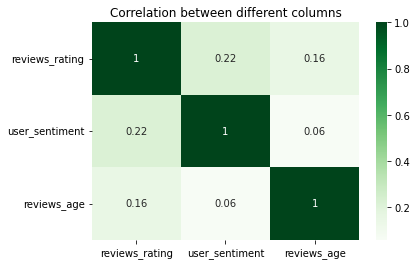

In [65]:
sns.heatmap(df.corr(), cmap="Greens", annot=True)
plt.title("Correlation between different columns")
plt.show()

### Analyze column lengths

In [66]:
df['name'].str.len().describe()

count    29658.000000
mean        53.301065
std         14.152037
min         13.000000
25%         44.000000
50%         57.000000
75%         63.000000
max        103.000000
Name: name, dtype: float64

c:\users\aadit\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='name', ylabel='Density'>

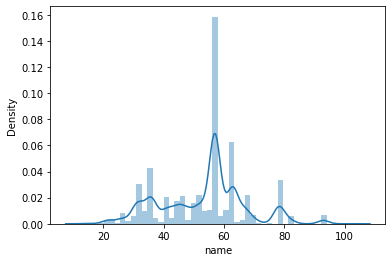

In [67]:
sns.distplot(df['name'].str.len())

In [68]:
df['reviews'].str.len().describe()

count    29658.000000
mean       200.992616
std        185.824803
min          6.000000
25%        100.000000
50%        148.000000
75%        237.000000
max       5762.000000
Name: reviews, dtype: float64

c:\users\aadit\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='reviews', ylabel='Density'>

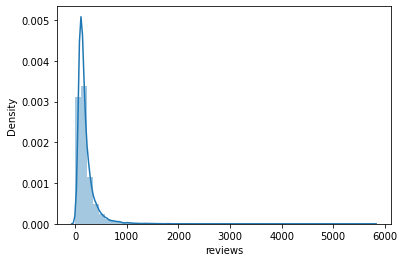

In [69]:
sns.distplot(df['reviews'].str.len())

### Strip the review length to 99%

In [70]:
reviews_truncated_len = df['reviews'].str.len().quantile(0.99)
reviews_truncated_len

908.4300000000003

In [71]:
df['reviews'] = df['reviews'].str.slice(0,int(reviews_truncated_len))

In [72]:
df['reviews'].str.len().describe()

count    29658.000000
mean       196.886911
std        154.288785
min          6.000000
25%        100.000000
50%        148.000000
75%        237.000000
max        908.000000
Name: reviews, dtype: float64

c:\users\aadit\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='reviews', ylabel='Density'>

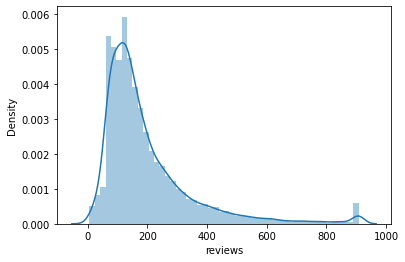

In [73]:
sns.distplot(df['reviews'].str.len())

## Text preprocessing

### Create custom stop words for better processing

In [74]:
stopword_list = sorted(stopwords.words('english'))
stopword_list

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [75]:
useful_stop_words = ['again', 'against', "aren't", 'can', "couldn't", 'did', 
                     "didn't", 'do', 'does', "doesn't", "don't", 'down',
                     "hadn't", "hasn't", "haven't", "isn't", "mustn't",
                     "needn't", 'no', 'nor', 'not', 'off', 'on', "shouldn't", 
                     "wasn't", "weren't", "wouldn't"]

In [76]:
custom_stopword_list = [element for element in stopword_list if element not in useful_stop_words]
custom_stopword_list

['a',
 'about',
 'above',
 'after',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'couldn',
 'd',
 'didn',
 'doesn',
 'doing',
 'don',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 'has',
 'hasn',
 'have',
 'haven',
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 'my',
 'myself',
 'needn',
 'now',
 'o',
 'of',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'shan',
 "shan't",
 'she',
 "she's",
 'should',
 "should've",
 'shouldn',
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 "that'll",
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',

In [77]:
len(custom_stopword_list)

152

In [78]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
#     a= [i for i in string.split() if i not in stopwords.words('english')]
    a= [i for i in string.split() if i not in custom_stopword_list]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Tokenize the sentence
def lemmatizer(string):
     # Get position tags
    word_pos_tags = nltk.pos_tag(word_tokenize(string))
    # Map the position tag and lemmatize the word/token
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] 
    return " ".join(a)

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], get_wordnet_pos(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(wl.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

def finalpreprocess(string):
    return lemmatize_sentence(stopword(preprocess(string)))

In [79]:
%%time
df['reviews'] = df['reviews'].apply(lambda x: finalpreprocess(x))

Wall time: 54.1 s


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29658 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              29658 non-null  object
 1   reviews_rating    29658 non-null  int64 
 2   reviews_username  29658 non-null  object
 3   user_sentiment    29658 non-null  int64 
 4   reviews_age       29658 non-null  int64 
 5   reviews           29658 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.6+ MB


In [81]:
df.head()

,name,reviews_rating,reviews_username,user_sentiment,reviews_age,reviews
0,Pink Friday: Roman Reloaded Re-Up (W/Dvd),5,joshua,1,9,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,4,good good flavor review collect part promotion
2,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,4,good good flavor
3,K-Y Love Sensuality Pleasure Gel,1,rebecca,0,5,disappoint read review on look buy one couple lubricant ultimately disappointed even live review read starter neither boyfriend nor could notice sort enhanced captivate sensation do notice however messy consistency reminiscent liquid vaseline difficult clean not pleasant especially since lack captivate sensation expect disappoint pay much do lube use again could use normal personal lubricant less money less mess
4,K-Y Love Sensuality Pleasure Gel,1,walker557,0,5,irritation husband buy gel u gel caused irritation felt like burn skin recommend gel


### Create a df with only product name and reviews and pickle it.
### This df is going to be used while recommending the final top 5 products

In [82]:
product_name_reviews_df = df[["name", "reviews"]]
product_name_reviews_df

,name,reviews
0,Pink Friday: Roman Reloaded Re-Up (W/Dvd),awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,Lundberg Organic Cinnamon Toast Rice Cakes,good good flavor review collect part promotion
2,Lundberg Organic Cinnamon Toast Rice Cakes,good good flavor
3,K-Y Love Sensuality Pleasure Gel,disappoint read review on look buy one couple lubricant ultimately disappointed even live review read starter neither boyfriend nor could notice sort enhanced captivate sensation do notice however messy consistency reminiscent liquid vaseline difficult clean not pleasant especially since lack captivate sensation expect disappoint pay much do lube use again could use normal personal lubricant less money less mess
4,K-Y Love Sensuality Pleasure Gel,irritation husband buy gel u gel caused irritation felt like burn skin recommend gel
...,...,...
29995,L'Or233Al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,softness get conditioner influenster try im love far oily hair use end hair feel amaze soft no mess review collect part promotion
29996,L'Or233Al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,love love receive review purpose influenster leave hair feel fresh smelling great
29997,L'Or233Al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,hair smooth use first love smell product wash hair smooth easy brush do receive product influenster test purpose opinion review collect part promotion
29998,L'Or233Al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,perfect oily hair receive influenster never go back anything else normally use conditioner hair oily fine do not make hair feel heavy get oily day really fantastic plan on buy future review collect part promotion


### Commenting the pickle file creation for this notebook user
### This was used on the initial run

In [83]:
# product_name_reviews_df.to_pickle("pickle_files/cleaned_df.pkl")

## Feature extraction

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29658 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              29658 non-null  object
 1   reviews_rating    29658 non-null  int64 
 2   reviews_username  29658 non-null  object
 3   user_sentiment    29658 non-null  int64 
 4   reviews_age       29658 non-null  int64 
 5   reviews           29658 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.6+ MB


In [85]:
df.head()

,name,reviews_rating,reviews_username,user_sentiment,reviews_age,reviews
0,Pink Friday: Roman Reloaded Re-Up (W/Dvd),5,joshua,1,9,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,4,good good flavor review collect part promotion
2,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,4,good good flavor
3,K-Y Love Sensuality Pleasure Gel,1,rebecca,0,5,disappoint read review on look buy one couple lubricant ultimately disappointed even live review read starter neither boyfriend nor could notice sort enhanced captivate sensation do notice however messy consistency reminiscent liquid vaseline difficult clean not pleasant especially since lack captivate sensation expect disappoint pay much do lube use again could use normal personal lubricant less money less mess
4,K-Y Love Sensuality Pleasure Gel,1,walker557,0,5,irritation husband buy gel u gel caused irritation felt like burn skin recommend gel


In [86]:
# x = df[['reviews_rating', 'reviews_age', 'reviews']]
x = df[['reviews']]

In [87]:
y = df['user_sentiment']

In [88]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29658 entries, 0 to 29999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  29658 non-null  object
dtypes: object(1)
memory usage: 463.4+ KB


In [89]:
x.shape

(29658, 1)

In [90]:
y.shape

(29658,)

In [91]:
y

0        1
1        1
2        1
3        0
4        0
        ..
29995    1
29996    1
29997    1
29998    1
29999    1
Name: user_sentiment, Length: 29658, dtype: int64

## Helper functions for pipelines and model analysis

In [92]:
def draw_roc(actual, probs, classifier_name, datatype):
    fpr, tpr, thresholds = roc_curve(actual, probs,
                                     drop_intermediate = False)
    auc_score = roc_auc_score(actual, probs)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{classifier_name} - {datatype} - ROC curve")
    plt.legend(loc="lower right")
    plt.show()

In [93]:
def pipeline_processor(classifier):

    classifier_name = type(classifier).__name__
    pipeline = imblearn_make_pipeline(
                column_transformer,
                sm,
                classifier)

    print("="*40 + f"\n{classifier_name}\n" + "="*40)
    print("\n")
    print(pipeline.fit(X_train, y_train))
    
    # Prediction Train Data
    print("-"*40 + f"\nTrain\n" + "-"*40)
    y_pred_train= pipeline.predict(X_train)
    print(f"* {classifier_name} Train accuracy:", accuracy_score(y_pred_train, y_train))
    print(f"\n* {classifier_name} Train Classification Report")
    print(classification_report(y_pred_train, y_train))
    print(f"\n* {classifier_name} Train Confusion Matrix")
    print(confusion_matrix(y_pred_train, y_train))
    draw_roc(y_train, y_pred_train, classifier_name, "Train")
    
    # Prediction Test Data
    print("-"*40 + f"\nTest\n" + "-"*40)
    y_pred_test = pipeline.predict(X_test)
    print(f"* {classifier_name} Test accuracy:", accuracy_score(y_pred_test, y_test))
    print(f"\n* {classifier_name} Test Classification Report")
    print(classification_report(y_pred_test, y_test))
    print(f"\n* {classifier_name} Test Confusion Matrix")
    print(confusion_matrix(y_pred_test, y_test))
    draw_roc(y_test, y_pred_test, classifier_name, "Test")

In [94]:
def pipeline_processor_grid_cv(classifier, grid_params):

    classifier_name = type(classifier).__name__
    pipeline = imblearn_make_pipeline(
                column_transformer,
                sm,
                classifier)

    print("="*40 + f"\n{classifier_name}\n" + "="*40)
    print("\n")
    
    # create 5 folds
    folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)
    scorer = make_scorer(roc_auc_score,
                         greater_is_better=True,
                         needs_proba=True,
                         needs_threshold=False)
    gridsearch = GridSearchCV(pipeline,
                              param_grid=grid_params, 
                              cv=folds,
                              scoring=scorer,
                              verbose=0,
                              n_jobs=-1) 
    print(gridsearch.fit(X_train, y_train))
    
    model = gridsearch.best_estimator_
    print("*"*40 + f"\nBest model for {classifier_name}\n" + "*"*40)
    print(f"\n{model}\n" + "*"*40)
    print("\n")
    
    # Prediction Train Data
    print("-"*40 + f"\nTrain\n" + "-"*40)
    y_pred_train= model.predict(X_train)
    print(f"* {classifier_name} Train accuracy:", accuracy_score(y_pred_train, y_train))
    print(f"\n* {classifier_name} Train Classification Report")
    print(classification_report(y_pred_train, y_train))
    print(f"\n* {classifier_name} Train Confusion Matrix")
    print(confusion_matrix(y_pred_train, y_train))
    draw_roc(y_train, y_pred_train, classifier_name, "Train")
    
    # Prediction Test Data
    print("-"*40 + f"\nTest\n" + "-"*40)
    y_pred_test = model.predict(X_test)
    print(f"* {classifier_name} Test accuracy:", accuracy_score(y_pred_test, y_test))
    print(f"\n* {classifier_name} Test Classification Report")
    print(classification_report(y_pred_test, y_test))
    print(f"\n* {classifier_name} Test Confusion Matrix")
    print(confusion_matrix(y_pred_test, y_test))
    draw_roc(y_test, y_pred_test, classifier_name, "Test")

##  Model building

### Below are the potential models we are going to try

### 1. Logistic Regression

### 2. Naive Bayes

### 3. Random Forest

### 4. XGBoost

In [95]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=100)

In [96]:
word_vectorizer = TfidfVectorizer(
    lowercase= True,
    strip_accents='unicode',    # Remove accents and perform other character normalization during the preprocessing step. 
    analyzer='word',            # Whether the feature should be made of word or character n-grams.
    token_pattern=r'\w{1,}',    # Regular expression denoting what constitutes a “token”, only used if analyzer == 'word'
    ngram_range=(1, 3),         # The lower and upper boundary of the range of n-values for different n-grams to be extracted
    stop_words='english',
    max_features=10000,
    sublinear_tf=True)

# word_vectorizer.fit(X_train['reviews_text'])    # Fiting it on Train
# train_word_features = word_vectorizer.transform(X_train['reviews_title'])  # Transform on Train

In [97]:
column_transformer = make_column_transformer(
    (word_vectorizer, 'reviews'),
    remainder='passthrough')

In [98]:
sm = SMOTE(random_state=100)

#### Logistic Regression Model

In [99]:
lr_classifier = LogisticRegression(solver='lbfgs', max_iter=2000, random_state=100, penalty='l2', C='0.9')

In [100]:
lr_grid_params = {
    "logisticregression__solver": ['liblinear', 'saga', 'lbfgs', 'sag'],
    "logisticregression__class_weight": ['balanced', None],
    "logisticregression__penalty": ['l1', 'l2', 'elasticnet'],
    "logisticregression__C": [1.0, 0.9, 0.8]
}

#### Naive Vayes Model

In [101]:
mnb_classifier = MultinomialNB()

In [102]:
mnd_grid_params = {
    'multinomialnb__alpha': [10.0, 15.0, 20.0, 25.0, 30.0]
}

#### Random Forest Model

In [103]:
rf_classifier = RandomForestClassifier(max_depth=5, max_leaf_nodes=10, n_estimators=1000, n_jobs=-1, random_state=100)

In [104]:
rf_grid_params = {
    "randomforestclassifier__max_depth": [2, 3, 4, 5, 8],
    "randomforestclassifier__n_estimators": [1000, 2500, 5000],
    "randomforestclassifier__max_features": ['auto', 'sqrt', 'log2'],
    "randomforestclassifier__criterion": ['gini', 'entropy'],
    "randomforestclassifier__max_leaf_nodes": [10, 20, 50, 100],
    "randomforestclassifier__class_weight": ["balanced", "balanced_subsample", None]
}

#### XGBoost Model

In [105]:
xgb_classifier = XGBClassifier(random_state=100, n_jobs=-1, use_label_encoder=False, class_weight="balanced")

In [106]:
xgb_grid_params = {
    'xgbclassifier__n_estimators' : [100, 500, 1000, 2500, 5000], # no of trees 
    'xgbclassifier__learning_rate' : [0.01, 0.02, 0.05],  # eta
    'xgbclassifier__min_child_weight': [5, 10 , 20],
    'xgbclassifier__gamma': [0.1, 0.5, 1, 1.5, 5],
    'xgbclassifier__subsample': [0.6, 0.8, 1.0],
    'xgbclassifier__colsample_bytree': [0.6, 0.8],
    'xgbclassifier__max_depth': [5, 10, 15, 20]
}

## Executing the pipeline

#### I have created a pipeline which takes the reviews in text format as input.
#### The data is then passed through column transformer which converts the text into tfidf vectors.
#### Then SMOTE is applied on the data.
#### Finally a grid search CV of a classification model (Logistic Regression, Multinomial Naive Bayes, Random Forest and XGBoost) is trained which will do hyper-parameter tuning and create the best model
#### Classification report, confusion matrix and AUC is shown for the best model of each type 

# Warning: Below code contains hyper parameter tuning and it takes a lot of time to execute. Kindly execute this with care

In [731]:
classifier_param_tuple = [
    (lr_classifier, lr_grid_params),
    (mnb_classifier, mnd_grid_params),
    (rf_classifier, rf_grid_params),
    (xgb_classifier, xgb_grid_params),
]

LogisticRegression




c:\users\aadit\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.89849004 0.89852513        nan        nan 0.89885893 0.89884758
 0.89888593 0.89888767        nan        nan        nan        nan
 0.89849004 0.89852513        nan        nan 0.89885893 0.89884758
 0.89888593 0.89888767        nan        nan        nan        nan
 0.89903806 0.89907779        nan        nan 0.89865769 0.89865502
 0.89869787 0.8986988         nan        nan        nan        nan
 0.89903806 0.89907779        nan        nan 0.89865769 0.89865502
 0.89869787 0.8986988         nan        nan        nan        nan
 0.89938987 0.89944297        nan        nan 0.89836248 0.89835912
 0.89839781 0.89839735        nan        nan        nan        nan
 0.89938987 0.89944297        nan        nan 0.89836248 0.89835912
 0.89839781 0.89839735        nan        nan        nan        nan]
  category=UserWarning


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tfidfvectorizer',
                                                                         TfidfVectorizer(max_features=10000,
                                                                                         ngram_range=(1,
                                                                                                      3),
                                                                                         stop_words='english',
                                                                                         strip_accents='unicode',
                                                                                         sublinear_tf=True,
                                  

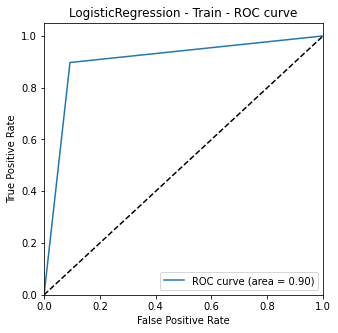

----------------------------------------
Test
----------------------------------------
* LogisticRegression Test accuracy: 0.8736441909873645

* LogisticRegression Test Classification Report
              precision    recall  f1-score   support

           0       0.74      0.46      0.57      1613
           1       0.89      0.96      0.93      7330

    accuracy                           0.87      8943
   macro avg       0.81      0.71      0.75      8943
weighted avg       0.86      0.87      0.86      8943


* LogisticRegression Test Confusion Matrix
[[ 750  863]
 [ 267 7063]]


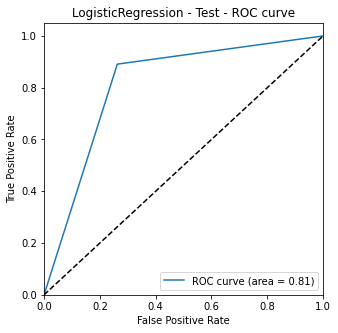

MultinomialNB


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tfidfvectorizer',
                                                                         TfidfVectorizer(max_features=10000,
                                                                                         ngram_range=(1,
                                                                                                      3),
                                                                                         stop_words='english',
                                                                                         strip_accents='unicode',
                                                                                         sublinear_tf=True,
                  

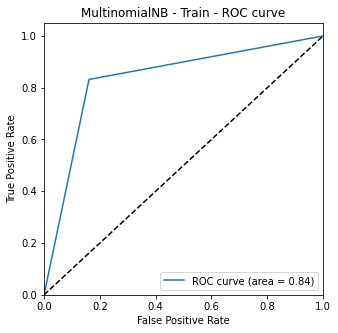

----------------------------------------
Test
----------------------------------------
* MultinomialNB Test accuracy: 0.8047635021804763

* MultinomialNB Test Classification Report
              precision    recall  f1-score   support

           0       0.69      0.33      0.45      2137
           1       0.82      0.95      0.88      6806

    accuracy                           0.80      8943
   macro avg       0.76      0.64      0.66      8943
weighted avg       0.79      0.80      0.78      8943


* MultinomialNB Test Confusion Matrix
[[ 704 1433]
 [ 313 6493]]


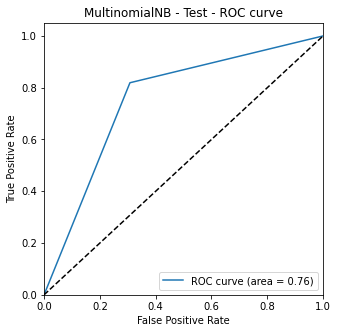

RandomForestClassifier


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tfidfvectorizer',
                                                                         TfidfVectorizer(max_features=10000,
                                                                                         ngram_range=(1,
                                                                                                      3),
                                                                                         stop_words='english',
                                                                                         strip_accents='unicode',
                                                                                         sublinear_tf=True,
         

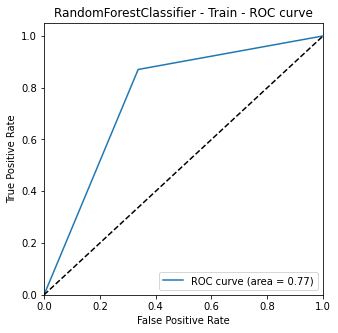

----------------------------------------
Test
----------------------------------------
* RandomForestClassifier Test accuracy: 0.836520183383652

* RandomForestClassifier Test Classification Report
              precision    recall  f1-score   support

           0       0.59      0.37      0.45      1651
           1       0.87      0.94      0.90      7292

    accuracy                           0.84      8943
   macro avg       0.73      0.65      0.68      8943
weighted avg       0.82      0.84      0.82      8943


* RandomForestClassifier Test Confusion Matrix
[[ 603 1048]
 [ 414 6878]]


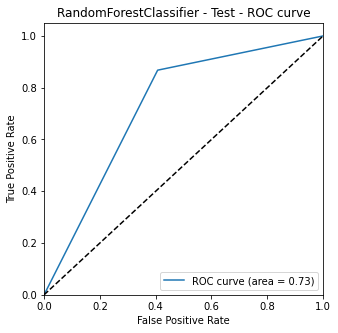

XGBClassifier




In [ ]:
%%time
for classifier, grid_params in classifier_param_tuple:
    pipeline_processor_grid_cv(classifier, grid_params)

In [126]:
xgb_grid_params = {
    'xgbclassifier__n_estimators' : [100, 500, 1000, 2500, 5000], # no of trees 
    'xgbclassifier__learning_rate' : [0.01, 0.02, 0.05],  # eta
    'xgbclassifier__min_child_weight': [5, 10 , 20],
    'xgbclassifier__gamma': [0.1, 0.5, 1, 1.5, 5],
    'xgbclassifier__subsample': [0.6, 0.8, 1.0],
    'xgbclassifier__colsample_bytree': [0.6, 0.8],
    'xgbclassifier__max_depth': [5, 10, 15, 20]
}

In [706]:
xgb_classifier = XGBClassifier(
    random_state=100,
    n_jobs=-1,
#     n_estimators=1000,
    learning_rate=0.01,
    subsample=0.8,
#     max_depth=15,
    use_label_encoder=False,
    class_weight="balanced")

In [704]:
xgb_classifier = XGBClassifier(random_state=100, n_jobs=-1, use_label_encoder=False, class_weight="balanced")

XGBClassifier


[16:28:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(max_features=10000,
                             

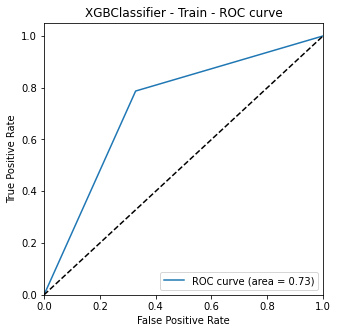

----------------------------------------
Test
----------------------------------------
* XGBClassifier Test accuracy: 0.7709597662396044

* XGBClassifier Test Classification Report
              precision    recall  f1-score   support

           0       0.63      0.27      0.38      2297
           1       0.79      0.94      0.86      6601

    accuracy                           0.77      8898
   macro avg       0.71      0.61      0.62      8898
weighted avg       0.75      0.77      0.74      8898


* XGBClassifier Test Confusion Matrix
[[ 631 1666]
 [ 372 6229]]


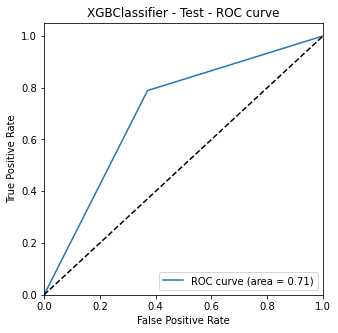

Wall time: 10.9 s


In [707]:
%%time
pipeline_processor(xgb_classifier)

# Best model is Logistic Regression with below paramaters

In [733]:
best_lr_classifier = LogisticRegression(solver='saga', max_iter=2000,
                                        random_state=100, penalty='l1',
                                        C=0.8, class_weight='balanced')

LogisticRegression


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(max_features=10000,
                                                                  ngram_range=(1,
                                                                               3),
                                                                  stop_words='english',
                                                                  strip_accents='unicode',
                                                                  sublinear_tf=True,
                                                                  token_pattern='\\w{1,}'),
                                                  'reviews')])),
                ('smote', SMOTE(random_state=100)),
                ('logisticregression',
                 LogisticRegression(C=0.8, class_

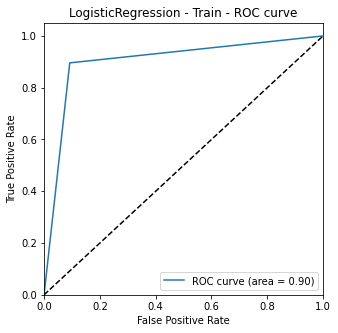

----------------------------------------
Test
----------------------------------------
* LogisticRegression Test accuracy: 0.8712070128118679

* LogisticRegression Test Classification Report
              precision    recall  f1-score   support

           0       0.76      0.46      0.57      1677
           1       0.88      0.97      0.92      7221

    accuracy                           0.87      8898
   macro avg       0.82      0.71      0.75      8898
weighted avg       0.86      0.87      0.86      8898


* LogisticRegression Test Confusion Matrix
[[ 767  910]
 [ 236 6985]]


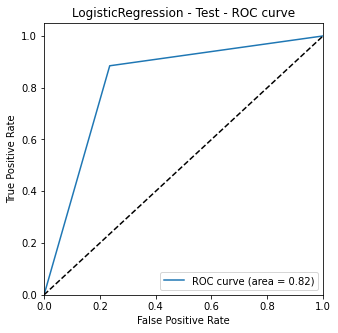

In [734]:
pipeline_processor(best_lr_classifier)

### Convert the model into a pickle file

In [735]:
pipeline = imblearn_make_pipeline(column_transformer, sm, best_lr_classifier)

In [736]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(max_features=10000,
                                                                  ngram_range=(1,
                                                                               3),
                                                                  stop_words='english',
                                                                  strip_accents='unicode',
                                                                  sublinear_tf=True,
                                                                  token_pattern='\\w{1,}'),
                                                  'reviews')])),
                ('smote', SMOTE(random_state=100)),
                ('logisticregression',
                 LogisticRegression(C=0.8, class_weight='balanced',
  

### Commenting the pickle file creation for this notebook user
### This was used on the initial run

In [737]:
# joblib.dump(pipeline, "pickle_files/lr_model.pkl")

['lr_model.pkl']

# Recommendation Systems

### Below are the recommendation systems are we going to try

### 1. User-based recommendation system

### 2. Item-based recommendation system

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29658 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              29658 non-null  object
 1   reviews_rating    29658 non-null  int64 
 2   reviews_username  29658 non-null  object
 3   user_sentiment    29658 non-null  int64 
 4   reviews_age       29658 non-null  int64 
 5   reviews           29658 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.6+ MB


In [108]:
df.head()

,name,reviews_rating,reviews_username,user_sentiment,reviews_age,reviews
0,Pink Friday: Roman Reloaded Re-Up (W/Dvd),5,joshua,1,9,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,4,good good flavor review collect part promotion
2,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,1,4,good good flavor
3,K-Y Love Sensuality Pleasure Gel,1,rebecca,0,5,disappoint read review on look buy one couple lubricant ultimately disappointed even live review read starter neither boyfriend nor could notice sort enhanced captivate sensation do notice however messy consistency reminiscent liquid vaseline difficult clean not pleasant especially since lack captivate sensation expect disappoint pay much do lube use again could use normal personal lubricant less money less mess
4,K-Y Love Sensuality Pleasure Gel,1,walker557,0,5,irritation husband buy gel u gel caused irritation felt like burn skin recommend gel


## Use name, reviews_rating and reviews_username are the columns used for recommendation system

In [109]:
df_recom = df[['name', 'reviews_rating', 'reviews_username']].copy()

In [110]:
df_recom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29658 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              29658 non-null  object
 1   reviews_rating    29658 non-null  int64 
 2   reviews_username  29658 non-null  object
dtypes: int64(1), object(2)
memory usage: 926.8+ KB


In [111]:
df_recom.head()

,name,reviews_rating,reviews_username
0,Pink Friday: Roman Reloaded Re-Up (W/Dvd),5,joshua
1,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,K-Y Love Sensuality Pleasure Gel,1,walker557


### Remove duplicates

In [112]:
df_recom.shape

(29658, 3)

In [113]:
df_recom.drop_duplicates(inplace=True)

In [114]:
df_recom.shape

(27739, 3)

### Check user_id and product_id combination is unique or not

In [115]:
vectorize_fun = np.vectorize(lambda x,y:str(x)+str(y))

In [116]:
vectorize_fun(df_recom['reviews_username'],df_recom['name'])

array(['joshuaPink Friday: Roman Reloaded Re-Up (W/Dvd)',
       'dorothy wLundberg Organic Cinnamon Toast Rice Cakes',
       'rebeccaK-Y Love Sensuality Pleasure Gel', ...,
       "liviasuexoL'Or233Al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz",
       "ktreed95L'Or233Al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz",
       "kcoopxoxoL'Or233Al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz"],
      dtype='<U119')

In [117]:
len(set(vectorize_fun(df_recom['reviews_username'],df_recom['name'])))

27588

#### There are still duplicates in the data
#### We can take the mean of all ratings to remove duplicates

In [118]:
df_recom_clean = df_recom.groupby(['reviews_username','name']).mean('reviews_rating').reset_index()

In [119]:
df_recom_clean

,reviews_username,name,reviews_rating
0,00dog3,Chex Muddy Buddies Brownie Supreme Snack Mix,4.0
1,00sab00,Mike Dave Need Wedding Dates (Dvd + Digital),1.0
2,00sab00,My Big Fat Greek Wedding 2 (Blu-Ray + Dvd + Digital),3.0
3,01impala,Godzilla 3D Includes Digital Copy Ultraviolet 3D/2D Blu-Ray/Dvd,3.0
4,02dakota,Godzilla 3D Includes Digital Copy Ultraviolet 3D/2D Blu-Ray/Dvd,5.0
...,...,...,...
27583,zxcsdfd,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5.0
27584,zxjki,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,2.0
27585,zyiah4,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5.0
27586,zzdiane,My Big Fat Greek Wedding 2 (Blu-Ray + Dvd + Digital),5.0


In [120]:
df_recom_clean.nunique()

reviews_username    24914
name                  271
reviews_rating         12
dtype: int64

In [121]:
len(set(vectorize_fun(df_recom['reviews_username'],df_recom['name'])))

27588

### No more duplicates

### Create a train-test split

In [122]:
df_train, df_test = train_test_split(df_recom_clean, train_size=0.75, random_state=50)

In [123]:
print(df_train.shape)
print(df_test.shape)

(20691, 3)
(6897, 3)


# User Based recommendation

### Now we can create our pivot table for recommendation system

In [124]:
df_pivot = df_train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)
df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (Blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2X Ultra Era With Oxi Booster, 50Fl Oz",4C Grated Parmesan Cheese 100% Natural 8Oz Shaker,5302050 15/16 Fct/Hose Adaptor,Africa'S Best No-Lye Dual Conditioning Relaxer System Super,Alberto Vo5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (Dvdvideo),"All,Bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie'S Homegrown Deluxe Elbows & Four Cheese Sauce,Annie'S Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, Spf 4","Aveeno Baby Continuous Protection Lotion Sunscreen With Broad Spectrum Spf 55, 4Oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 Oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry'S Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-Kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (Cd),Bisquick Original Pancake And Baking Mix - 40Oz,Black Front Loading Frame Set (8.5X11) Set Of 12,Black Sister'S Revenge (Dvd),Blue Anchor Design Throw Pillow (18X18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 Sheets","Bridgestone 130/70Zr18M/C(63W)Front Exedra G851, Cruiser Radl",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt'S Bees Lip Shimmer, Raisin","Burt'S Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 Pk",Cantu Coconut Milk Shine Hold Mist - 8Oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75Oz",Cars Toon: Mater'S Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,Cerave Sa Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2Oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester'S Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2Oz,Chips Deluxe Soft 'N Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3Oz,Citrus Magic Instant Spot & Stain Remover,Clambake (Dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood Ceiling Mounted Pot Rack,Coola Organic Sunscreen Classic Face Cucumber Spf 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3Ct,Dark Shadows (Includes Digital Copy) (Ultraviolet) (Dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4Oz",Diet Canada Dry Ginger Ale - 12Pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (Cd),Equals (Blu-Ray),Every Man Jack Pomade Signature Mint Scent,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, O

In [125]:
df_pivot.shape

(19067, 260)

### Creating dummy train & dummy test dataset

In [126]:
# Copy the train dataset into dummy_train
dummy_train = df_train.copy()

In [127]:
# The product not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [128]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(1)

In [129]:
dummy_train.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (Blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2X Ultra Era With Oxi Booster, 50Fl Oz",4C Grated Parmesan Cheese 100% Natural 8Oz Shaker,5302050 15/16 Fct/Hose Adaptor,Africa'S Best No-Lye Dual Conditioning Relaxer System Super,Alberto Vo5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (Dvdvideo),"All,Bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie'S Homegrown Deluxe Elbows & Four Cheese Sauce,Annie'S Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, Spf 4","Aveeno Baby Continuous Protection Lotion Sunscreen With Broad Spectrum Spf 55, 4Oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 Oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry'S Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-Kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (Cd),Bisquick Original Pancake And Baking Mix - 40Oz,Black Front Loading Frame Set (8.5X11) Set Of 12,Black Sister'S Revenge (Dvd),Blue Anchor Design Throw Pillow (18X18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 Sheets","Bridgestone 130/70Zr18M/C(63W)Front Exedra G851, Cruiser Radl",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt'S Bees Lip Shimmer, Raisin","Burt'S Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 Pk",Cantu Coconut Milk Shine Hold Mist - 8Oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75Oz",Cars Toon: Mater'S Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,Cerave Sa Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2Oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester'S Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2Oz,Chips Deluxe Soft 'N Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3Oz,Citrus Magic Instant Spot & Stain Remover,Clambake (Dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood Ceiling Mounted Pot Rack,Coola Organic Sunscreen Classic Face Cucumber Spf 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3Ct,Dark Shadows (Includes Digital Copy) (Ultraviolet) (Dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4Oz",Diet Canada Dry Ginger Ale - 12Pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (Cd),Equals (Blu-Ray),Every Man Jack Pomade Signature Mint Scent,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, O

### Normalising the rating of the product for each user around 0 mean

In [130]:
mean = np.nanmean(dummy_train, axis=1)
df_subtracted = (dummy_train.T-mean).T

In [131]:
df_subtracted.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (Blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2X Ultra Era With Oxi Booster, 50Fl Oz",4C Grated Parmesan Cheese 100% Natural 8Oz Shaker,5302050 15/16 Fct/Hose Adaptor,Africa'S Best No-Lye Dual Conditioning Relaxer System Super,Alberto Vo5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (Dvdvideo),"All,Bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie'S Homegrown Deluxe Elbows & Four Cheese Sauce,Annie'S Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, Spf 4","Aveeno Baby Continuous Protection Lotion Sunscreen With Broad Spectrum Spf 55, 4Oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 Oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry'S Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-Kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (Cd),Bisquick Original Pancake And Baking Mix - 40Oz,Black Front Loading Frame Set (8.5X11) Set Of 12,Black Sister'S Revenge (Dvd),Blue Anchor Design Throw Pillow (18X18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 Sheets","Bridgestone 130/70Zr18M/C(63W)Front Exedra G851, Cruiser Radl",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt'S Bees Lip Shimmer, Raisin","Burt'S Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 Pk",Cantu Coconut Milk Shine Hold Mist - 8Oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75Oz",Cars Toon: Mater'S Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,Cerave Sa Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2Oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester'S Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2Oz,Chips Deluxe Soft 'N Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3Oz,Citrus Magic Instant Spot & Stain Remover,Clambake (Dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood Ceiling Mounted Pot Rack,Coola Organic Sunscreen Classic Face Cucumber Spf 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3Ct,Dark Shadows (Includes Digital Copy) (Ultraviolet) (Dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4Oz",Diet Canada Dry Ginger Ale - 12Pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (Cd),Equals (Blu-Ray),Every Man Jack Pomade Signature Mint Scent,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, O

## User Similarity matrix

### Using Cosine Similarity

In [132]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[ 1.         -0.00547086 -0.003861   ... -0.003861   -0.003861
  -0.003861  ]
 [-0.00547086  1.         -0.00547086 ... -0.00547086  0.70574039
  -0.00547086]
 [-0.003861   -0.00547086  1.         ... -0.003861   -0.003861
  -0.003861  ]
 ...
 [-0.003861   -0.00547086 -0.003861   ...  1.         -0.003861
   1.        ]
 [-0.003861    0.70574039 -0.003861   ... -0.003861    1.
  -0.003861  ]
 [-0.003861   -0.00547086 -0.003861   ...  1.         -0.003861
   1.        ]]


In [133]:
user_correlation.shape

(19067, 19067)

### Prediction - User User

In [134]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.70574039,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.        , 0.70574039, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ]])

In [135]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[ 0.        ,  0.        ,  0.        , ...,  1.74371458,
         0.        ,  0.        ],
       [ 0.        ,  5.52346539,  0.        , ..., 13.34590126,
         4.09142033,  1.68938132],
       [ 0.        ,  6.40428594,  0.        , ..., 17.00336334,
         2.30046719,  3.39807836],
       ...,
       [ 0.        ,  6.80268404,  0.        , ..., 13.18452905,
         2.21873386,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., 11.01696002,
         5.82916914,  1.86780427],
       [ 0.        ,  6.80268404,  0.        , ..., 13.18452905,
         2.21873386,  0.        ]])

In [136]:
user_predicted_ratings.shape

(19067, 260)

In [137]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (Blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2X Ultra Era With Oxi Booster, 50Fl Oz",4C Grated Parmesan Cheese 100% Natural 8Oz Shaker,5302050 15/16 Fct/Hose Adaptor,Africa'S Best No-Lye Dual Conditioning Relaxer System Super,Alberto Vo5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (Dvdvideo),"All,Bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie'S Homegrown Deluxe Elbows & Four Cheese Sauce,Annie'S Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, Spf 4","Aveeno Baby Continuous Protection Lotion Sunscreen With Broad Spectrum Spf 55, 4Oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 Oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry'S Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-Kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (Cd),Bisquick Original Pancake And Baking Mix - 40Oz,Black Front Loading Frame Set (8.5X11) Set Of 12,Black Sister'S Revenge (Dvd),Blue Anchor Design Throw Pillow (18X18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 Sheets","Bridgestone 130/70Zr18M/C(63W)Front Exedra G851, Cruiser Radl",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt'S Bees Lip Shimmer, Raisin","Burt'S Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 Pk",Cantu Coconut Milk Shine Hold Mist - 8Oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75Oz",Cars Toon: Mater'S Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,Cerave Sa Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2Oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester'S Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2Oz,Chips Deluxe Soft 'N Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3Oz,Citrus Magic Instant Spot & Stain Remover,Clambake (Dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood Ceiling Mounted Pot Rack,Coola Organic Sunscreen Classic Face Cucumber Spf 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3Ct,Dark Shadows (Includes Digital Copy) (Ultraviolet) (Dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4Oz",Diet Canada Dry Ginger Ale - 12Pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (Cd),Equals (Blu-Ray),Every Man Jack Pomade Signature Mint Scent,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, O

In [138]:
user_final_rating.shape

(19067, 260)

### Finding the top 5 recommendation for the *user*

In [139]:
# Take the user ID as input.
# user_input = input("Enter your user name")
user_input = "00dog3"
print(user_input)

00dog3


In [140]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

name
Planes: Fire Rescue (2 Discs) (Includes Digital Copy) (Blu-Ray/Dvd)                    7.795130
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                              7.104778
Hormel Chili, No Beans                                                                 4.275824
My Big Fat Greek Wedding 2 (Blu-Ray + Dvd + Digital)                                   3.611519
Clorox Disinfecting Bathroom Cleaner                                                   3.611519
Mike Dave Need Wedding Dates (Dvd + Digital)                                           2.875584
Delta Single Handle Shower Faucet                                                      2.822962
Tostitos Bite Size Tortilla Chips                                                      2.485479
Chester'S Cheese Flavored Puffcorn Snacks                                              2.485479
Alex Cross (Dvdvideo)                                                                  2.300467
Power Crunch Protein Energy Bar Pea

## Evaluation - User User 

In [141]:
# Find out the common users of test and train dataset.
common = df_test[df_test['reviews_username'].isin(df_train['reviews_username'])]
common.shape

(958, 3)

In [142]:
common.head()

,reviews_username,name,reviews_rating
14990,lesliemdunn,Clorox Disinfecting Bathroom Cleaner,5.0
12467,john,The Resident Evil Collection 5 Discs (Blu-Ray),4.0
1102,amyw333,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5.0
12439,joey,My Big Fat Greek Wedding 2 (Blu-Ray + Dvd + Digital),5.0
21678,rick,Cococare 100% Natural Castor Oil,5.0


In [143]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [144]:
common_user_based_matrix.head()

name,100:Complete First Season (Blu-Ray),"42 Dual Drop Leaf Table With 2 Madrid Chairs""",Alex Cross (Dvdvideo),"All,Bran Complete Wheat Flakes, 18 Oz.","Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, Spf 4","Aveeno Baby Continuous Protection Lotion Sunscreen With Broad Spectrum Spf 55, 4Oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bi-O-Kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40Oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 Sheets","Bridgestone 130/70Zr18M/C(63W)Front Exedra G851, Cruiser Radl","Burt'S Bees Lip Shimmer, Raisin","Caress Moisturizing Body Bar Natural Silk, 4.75Oz",Cars Toon: Mater'S Tall Tales,Cerave Sa Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2Oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester'S Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2Oz,Chips Deluxe Soft 'N Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3Oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Cococare 100% Natural Castor Oil,"Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3Ct,Dark Shadows (Includes Digital Copy) (Ultraviolet) (Dvdvideo),Diet Canada Dry Ginger Ale - 12Pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Equals (Blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Godzilla 3D Includes Digital Copy Ultraviolet 3D/2D Blu-Ray/Dvd,Happy Tot Apple And Butternut Squash,Head & Shoulders Classic Clean Conditioner,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500W Hfh131-N,Home Health Hairever Shampoo,Honeywell Heatbud Ceramic Heater Black,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010Com,"Hormel Chili, No Beans",J.A. Henckels International 4-Pc Everedge Plus Steak Knife Set,Jason Aldean - They Don'T Know,"Johnson'S Baby Bubble Bath And Wash, 15Oz",Jolly Time Select Premium Yellow Pop Corn,"Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",K-Y Love Sensuality Pleasure Gel,Kendall Comforter And Sheet Set (Twin) Aqua - 7Pc,Kind Nut Delight Bar,L'Or233Al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,Leslie Sansone:Belly Blasting Walk (Dvd),"Lundberg Wehani Rice, 25Lb","Lysol Concentrate Deodorizing Cleaner, Original Scent",Maranatha No Stir Raw Maple Almond Butter,Meguiar'S Deep Crystal Car Wash 64-Oz.,Meguiar'S Ultimate Quik Detailer 22-Oz.,Meguiars Interior Detailer Wipes 25Ct,Mike Dave Need Wedding Dates (Dvd + Digital),Mill Creek Aloe Vera & Paba Lotion,Moom Express Pre Waxed Strips For Face & Bikini,Mrs. Meyer'S Lemon Verbena Surface Scrub,"Musselman Apple Sauce, Cinnamon, 48Oz",My Big Fat Greek Wedding 2 (Blu-Ray + Dvd + Digital),Nature'S Path Chunky Chocolate Peanut Chewy Granola Bars,Naturtint Nutrideep Multiplier Protective Cream,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum Spf 50, 5Oz","Newman'S Own Balsamic Vinaigrette, 16.0Oz","Newman'S Own Organics Licorice Twist, Black 5Oz",Nexxus Exxtra Gel Style Creation Sculptor,Ogx Anti-Breakage Keratin Oil 3 Minute Miraculous Recovery,"Ogx Conditioner, Hydrating Teatree Mint",Olay Regenerist Deep Hydration Regenerating Cream,Olivella Bar Soap - 3.52 Oz,Orajel Maximum Strength Toothache Pain Relief Liquid,"Pantene Color Preserve Volume Shampoo, 25.4Oz",Pantene Pro-V Expert Collection Age Defy Conditioner,"Pendaflex174 Divide It Up File Folder, Multi Section, 

In [145]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [146]:
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,18817,18818,18819,18820,18821,18822,18823,18824,18825,18826,18827,18828,18829,18830,18831,18832,18833,18834,18835,18836,18837,18838,18839,18840,18841,18842,18843,18844,18845,18846,18847,18848,18849,18850,18851,18852,18853,18854,18855,18856,18857,18858,18859,18860,18861,18862,18863,18864,18865,18866,18867,18868,18869,18870,18871,18872,18873,18874,18875,18876,18877,18878,18879,18880,18881,18882,18883,18884,18885,18886,18887,18888,18889,18890,18891,18892,18893,18894,18895,18896,18897,18898,18899,18900,18901,18902,18903,18904,18905,18906,18907,18908,18909,18910,18911,18912,18913,18914,18915,18916,18917,18918,18919,18920,18921,18922,18923,18924,18925,18926,18927,18928,18929,18930,18931,18932,18933,18934,18935,18936,18937,18938,18939,18940,18941,18942,18943,18944,18945,18946,18947,18948,18949,18950,18951,18952,18953,18954,18955,18956,18957,18958,18959,18960,18961,18962,18963,18964,18965,18966,18967,18968,18969,18970,18971,18972,18973,18974,18975,18976,18977,18978,18979,18980,18981,18982,18983,18984,18985,18986,18987,18988,18989,18990,18991,18992,18993,18994,18995,18996,18997,18998,18999,19000,19001,19002,19003,19004,19005,19006,19007,19008,19009,19010,19011,19012,19013,19014,19015,19016,19017,19018,19019,19020,19021,19022,19023,19024,19025,19026,19027,19028,19029,19030,19031,19032,19033,19034,19035,19036,19037,19038,19039,19040,19041,19042,19043,19044,19045,19046,19047,19048,19049,19050,19051,19052,19053,19054,19055,19056,19057,19058,19059,19060,19061,19062,19063,19064,19065,19066
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [147]:
df_pivot.index

Index(['00dog3', '00sab00', '01impala', '02dakota', '02deuce', '06stidriver', '08dallas', '09mommy11', '1.11e+24', '1085',
       ...
       'zsazsa', 'zt313', 'zubb', 'zulaa118', 'zwithanx', 'zxcsdfd', 'zxjki', 'zyiah4', 'zzdiane', 'zzz1127'], dtype='object', name='reviews_username', length=19067)

In [148]:
user_correlation_df['reviews_username'] = df_pivot.index

user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,18817,18818,18819,18820,18821,18822,18823,18824,18825,18826,18827,18828,18829,18830,18831,18832,18833,18834,18835,18836,18837,18838,18839,18840,18841,18842,18843,18844,18845,18846,18847,18848,18849,18850,18851,18852,18853,18854,18855,18856,18857,18858,18859,18860,18861,18862,18863,18864,18865,18866,18867,18868,18869,18870,18871,18872,18873,18874,18875,18876,18877,18878,18879,18880,18881,18882,18883,18884,18885,18886,18887,18888,18889,18890,18891,18892,18893,18894,18895,18896,18897,18898,18899,18900,18901,18902,18903,18904,18905,18906,18907,18908,18909,18910,18911,18912,18913,18914,18915,18916,18917,18918,18919,18920,18921,18922,18923,18924,18925,18926,18927,18928,18929,18930,18931,18932,18933,18934,18935,18936,18937,18938,18939,18940,18941,18942,18943,18944,18945,18946,18947,18948,18949,18950,18951,18952,18953,18954,18955,18956,18957,18958,18959,18960,18961,18962,18963,18964,18965,18966,18967,18968,18969,18970,18971,18972,18973,18974,18975,18976,18977,18978,18979,18980,18981,18982,18983,18984,18985,18986,18987,18988,18989,18990,18991,18992,18993,18994,18995,18996,18997,18998,18999,19000,19001,19002,19003,19004,19005,19006,19007,19008,19009,19010,19011,19012,19013,19014,19015,19016,19017,19018,19019,19020,19021,19022,19023,19024,19025,19026,19027,19028,19029,19030,19031,19032,19033,19034,19035,19036,19037,19038,19039,19040,19041,19042,19043,19044,19045,19046,19047,19048,19049,19050,19051,19052,19053,19054,19055,19056,19057,19058,19059,19060,19061,19062,19063,19064,19065,19066
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0

In [149]:
common.head()

,reviews_username,name,reviews_rating
14990,lesliemdunn,Clorox Disinfecting Bathroom Cleaner,5.0
12467,john,The Resident Evil Collection 5 Discs (Blu-Ray),4.0
1102,amyw333,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5.0
12439,joey,My Big Fat Greek Wedding 2 (Blu-Ray + Dvd + Digital),5.0
21678,rick,Cococare 100% Natural Castor Oil,5.0


In [150]:
list_name = common['reviews_username'].tolist()

user_correlation_df.columns = df_pivot.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [151]:
user_correlation_df_1.shape

(814, 19067)

In [152]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [153]:
user_correlation_df_3 = user_correlation_df_2.T

In [154]:
user_correlation_df_3.head()

,1234,1witch,aaron,abbey,abismomy,acg1,acjuarez08,adam,adriana,aimee,aisha,aj,aktcharlotte,alarm,alex,alice,allan6048,allison33,ally,amanda,amazing,amazon customer,amber,amcomber,amor,amy00381,amy75,amyw333,andy,ang32,angel,angie,anita,anne,anon,april,aria,arob,ash23,ash82085,ashley,auntie,aute8849,awesome,azchick,babs,backspace831,backstagepass475,bailee,baker,bakerbill,balvarado1970,banana,bargainhuntergmaoftwo,bargainshopper,bas56,batman,bb,bblack,bbshopper,bean,bearyshopper2,becky,becky39,bella,belle,bestbuyer,bestbuyfan,beth74,betsy,betty,beverly,bhere4u,bigb,bigdaddy,bkeys1965,blt66,blue,bob,bob1,bobbi,bobo,bonnieo,booboo,bowinkle,bpii,brandon,brandy04,brandy33,branjo12,breber1,bskye,bubbs33,bucket,buckeye,bullhorn,bunny,burntpopcorn,buster,busybee,busymom,buyer123,bwoh,bydave,bzylema,c,cait,cajw,calicutie,candice16542,carol,carsonensley,cass,cassandra,cat,catfan,cath,catl,ccccc,cdavadi,cecy89,champ,charles,charlie,chas,chasesmommy9810,checkersnova,chels3293,cher,chicosbrat6,chocolate,chraaaa,chris,chris22862002,chrissy,christina,christine,chuck,cindy,citykat808,cjsmom,cleaninglady30,cleanmama13,cleo,clubpeck,cmbradley123,cmerck2006,coco,cole,connie,connie36,cookie0258,coribecca,coronadad,cougar,cougs,couponmama,couponmom1996,couponsavvychick,court,cricket,cristyleigh,cry12,crystal,crystal132,cubby,cutemommyiam,dadof2b1g,daisymae19,dale,dana,dandan,daner,danielle,danny,darcie,darcy,darkoniv,datmanvell,dave,david1,dawn59,daynak9,dcom,debb,debbie,debbie2012,debi49,deborah,deda,delau,desi03,dharmiso,diana,diddy,diem,disappointed,disappointed customer,dizzle,djs2,djx1977,dkays02,dkhall85,dmobley,doll80,doloresnyc,dona,donna,donnap,dora,drabo,drea,drew,ducklove,dunamite47,eagle,earreaga,eddie,elizabeth,elizaraeb,ellen59,elway82,emerald,emf11,emily,emmylou,eric,erin,erin83,erwerw,esther,evecoup,evrydayhustla420,faithful,fallenangel2636,faye,ferenc,floyd,flyswimmer56,foxxygrrl75,francis,frank,fred,frenchy,fsheehan1104,gacouponmom,gamer1969,gary,gbowe,genk,...,mudcat75979,muffin,munchie77,musicman,nami,nan71,nanabanana,nanc,nancie2,nanette,nanna,nanny,natasha0712,nate,nativethoughts,ncmom2224,nelz214,nerdygirl,nettie,newmom10,nflmommy,nicknack,nicole,nicole35,nicole56,nikki89,nina,nmal,no nickname,noname,none,norbey,nrt1,nvbarby,okie,oliva,onthego,oscar,packersmumm,paige,palmettogirl,patty,pattycake,paul,paula,pauline1,pcmobile,pcomsec,peanut,peggy,pepper,petals66,pete,phil,phoebe,pink,pkrk,poisonivy,pooh,poppy,primoconcept,puck,quiltbee52,rachael,rachel,radicxs2,ralph,raul,ray92,rayray,realea,reba,redbeelips,reenins,reese,rena,renae,renee,rezanate,rhonda,ricashay24,richy,rick,rileysmommy4,rina808,riri,robb,robby,robert,robin,rocky,roger,rome,ronald,rosa,rosie,ross,roxy,rrrtjm,ruby,rudy,rufus,russ,ruthieruthie,sam1,sammi,sammy,sandra,sandra1234,sandy,sankoff,sarah,sarahb,sarala,sari,sassy,sassychic,scampertim,scan,scooter,scott,sdonovan724,segeld,senior,sewingmama,shaba,shalli,shannon82,sharon,sharpe,shawn,sheila,sheilakathleen,shelia,shelly,shellybelly,shofis82,shopper,shorty,sister,skooter,sleepymom,sleestak50,slim,slouchycowman,sls974,slufdriver,sm01,smiley,smithx3,smontell,snoopy,solathe2007,solo,sonny,sornum4,spicy918,spyguy,squeak,ssibeachbum,stacey,staci,staci29,staclove,stacy,star,stellasmama,steph65,stephanie,stephs,steve,sue,suewho,sunflower,sunny1,susan,susie,susie72,susu,suzanne,suzyq,sxctysix,taco99,takisha56ett,tami62,tammy,tango757,tara,tarheelfan,tausha,tb10,tdh51677,teacher,tee1969,teecherbabe,teresa,terie,terr,terry,tess,thai,thaot03,thebramblett4,thecleaninglady,thom,thomas,tiff,tiffany,tiffy,timothy,tina,tina40,tina71,tjab,tjhilburn,tjzmom,tobaira,todd,toddster7,tone,toni,tooney38,topaz0502,tracelyn28,treesmith,tricia,trina,truth,ttdebbi,twiggy575,tycr,typist,ulcunique,unnamed,vette,vicki,vickie,vicocious,victor,viewer,viking80,want297z,warren,weewee,wendy,wise,woowoo,wvshopaholic,yohnie1,zippy
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [155]:
user_correlation_df_3.shape

(814, 814)

In [156]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[13.53010961,  0.        ,  2.84633163, ...,  5.75116797,
         0.65110246, 13.70340155],
       [ 1.24273953,  3.52870195,  0.        , ...,  0.        ,
         1.15023359,  0.        ],
       [ 2.80730068,  0.        ,  1.23553146, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 6.24273953,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [13.10212527,  0.        ,  1.98449612, ...,  3.52870195,
         0.        , 11.96046003]])

In [157]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

In [158]:
dummy_test.shape

(814, 112)

In [159]:
common_user_based_matrix.head()

name,100:Complete First Season (Blu-Ray),"42 Dual Drop Leaf Table With 2 Madrid Chairs""",Alex Cross (Dvdvideo),"All,Bran Complete Wheat Flakes, 18 Oz.","Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, Spf 4","Aveeno Baby Continuous Protection Lotion Sunscreen With Broad Spectrum Spf 55, 4Oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bi-O-Kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40Oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 Sheets","Bridgestone 130/70Zr18M/C(63W)Front Exedra G851, Cruiser Radl","Burt'S Bees Lip Shimmer, Raisin","Caress Moisturizing Body Bar Natural Silk, 4.75Oz",Cars Toon: Mater'S Tall Tales,Cerave Sa Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2Oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester'S Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2Oz,Chips Deluxe Soft 'N Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3Oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Cococare 100% Natural Castor Oil,"Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3Ct,Dark Shadows (Includes Digital Copy) (Ultraviolet) (Dvdvideo),Diet Canada Dry Ginger Ale - 12Pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Equals (Blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Godzilla 3D Includes Digital Copy Ultraviolet 3D/2D Blu-Ray/Dvd,Happy Tot Apple And Butternut Squash,Head & Shoulders Classic Clean Conditioner,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500W Hfh131-N,Home Health Hairever Shampoo,Honeywell Heatbud Ceramic Heater Black,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010Com,"Hormel Chili, No Beans",J.A. Henckels International 4-Pc Everedge Plus Steak Knife Set,Jason Aldean - They Don'T Know,"Johnson'S Baby Bubble Bath And Wash, 15Oz",Jolly Time Select Premium Yellow Pop Corn,"Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",K-Y Love Sensuality Pleasure Gel,Kendall Comforter And Sheet Set (Twin) Aqua - 7Pc,Kind Nut Delight Bar,L'Or233Al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,Leslie Sansone:Belly Blasting Walk (Dvd),"Lundberg Wehani Rice, 25Lb","Lysol Concentrate Deodorizing Cleaner, Original Scent",Maranatha No Stir Raw Maple Almond Butter,Meguiar'S Deep Crystal Car Wash 64-Oz.,Meguiar'S Ultimate Quik Detailer 22-Oz.,Meguiars Interior Detailer Wipes 25Ct,Mike Dave Need Wedding Dates (Dvd + Digital),Mill Creek Aloe Vera & Paba Lotion,Moom Express Pre Waxed Strips For Face & Bikini,Mrs. Meyer'S Lemon Verbena Surface Scrub,"Musselman Apple Sauce, Cinnamon, 48Oz",My Big Fat Greek Wedding 2 (Blu-Ray + Dvd + Digital),Nature'S Path Chunky Chocolate Peanut Chewy Granola Bars,Naturtint Nutrideep Multiplier Protective Cream,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum Spf 50, 5Oz","Newman'S Own Balsamic Vinaigrette, 16.0Oz","Newman'S Own Organics Licorice Twist, Black 5Oz",Nexxus Exxtra Gel Style Creation Sculptor,Ogx Anti-Breakage Keratin Oil 3 Minute Miraculous Recovery,"Ogx Conditioner, Hydrating Teatree Mint",Olay Regenerist Deep Hydration Regenerating Cream,Olivella Bar Soap - 3.52 Oz,Orajel Maximum Strength Toothache Pain Relief Liquid,"Pantene Color Preserve Volume Shampoo, 25.4Oz",Pantene Pro-V Expert Collection Age Defy Conditioner,"Pendaflex174 Divide It Up File Folder, Multi Section, 

In [160]:
dummy_test.head()

name,100:Complete First Season (Blu-Ray),"42 Dual Drop Leaf Table With 2 Madrid Chairs""",Alex Cross (Dvdvideo),"All,Bran Complete Wheat Flakes, 18 Oz.","Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, Spf 4","Aveeno Baby Continuous Protection Lotion Sunscreen With Broad Spectrum Spf 55, 4Oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bi-O-Kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40Oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 Sheets","Bridgestone 130/70Zr18M/C(63W)Front Exedra G851, Cruiser Radl","Burt'S Bees Lip Shimmer, Raisin","Caress Moisturizing Body Bar Natural Silk, 4.75Oz",Cars Toon: Mater'S Tall Tales,Cerave Sa Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2Oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester'S Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2Oz,Chips Deluxe Soft 'N Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3Oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Cococare 100% Natural Castor Oil,"Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3Ct,Dark Shadows (Includes Digital Copy) (Ultraviolet) (Dvdvideo),Diet Canada Dry Ginger Ale - 12Pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Equals (Blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Godzilla 3D Includes Digital Copy Ultraviolet 3D/2D Blu-Ray/Dvd,Happy Tot Apple And Butternut Squash,Head & Shoulders Classic Clean Conditioner,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500W Hfh131-N,Home Health Hairever Shampoo,Honeywell Heatbud Ceramic Heater Black,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010Com,"Hormel Chili, No Beans",J.A. Henckels International 4-Pc Everedge Plus Steak Knife Set,Jason Aldean - They Don'T Know,"Johnson'S Baby Bubble Bath And Wash, 15Oz",Jolly Time Select Premium Yellow Pop Corn,"Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",K-Y Love Sensuality Pleasure Gel,Kendall Comforter And Sheet Set (Twin) Aqua - 7Pc,Kind Nut Delight Bar,L'Or233Al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,Leslie Sansone:Belly Blasting Walk (Dvd),"Lundberg Wehani Rice, 25Lb","Lysol Concentrate Deodorizing Cleaner, Original Scent",Maranatha No Stir Raw Maple Almond Butter,Meguiar'S Deep Crystal Car Wash 64-Oz.,Meguiar'S Ultimate Quik Detailer 22-Oz.,Meguiars Interior Detailer Wipes 25Ct,Mike Dave Need Wedding Dates (Dvd + Digital),Mill Creek Aloe Vera & Paba Lotion,Moom Express Pre Waxed Strips For Face & Bikini,Mrs. Meyer'S Lemon Verbena Surface Scrub,"Musselman Apple Sauce, Cinnamon, 48Oz",My Big Fat Greek Wedding 2 (Blu-Ray + Dvd + Digital),Nature'S Path Chunky Chocolate Peanut Chewy Granola Bars,Naturtint Nutrideep Multiplier Protective Cream,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum Spf 50, 5Oz","Newman'S Own Balsamic Vinaigrette, 16.0Oz","Newman'S Own Organics Licorice Twist, Black 5Oz",Nexxus Exxtra Gel Style Creation Sculptor,Ogx Anti-Breakage Keratin Oil 3 Minute Miraculous Recovery,"Ogx Conditioner, Hydrating Teatree Mint",Olay Regenerist Deep Hydration Regenerating Cream,Olivella Bar Soap - 3.52 Oz,Orajel Maximum Strength Toothache Pain Relief Liquid,"Pantene Color Preserve Volume Shampoo, 25.4Oz",Pantene Pro-V Expert Collection Age Defy Conditioner,"Pendaflex174 Divide It Up File Folder, Multi Section, 

In [161]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [162]:
common_user_predicted_ratings.head()

name,100:Complete First Season (Blu-Ray),"42 Dual Drop Leaf Table With 2 Madrid Chairs""",Alex Cross (Dvdvideo),"All,Bran Complete Wheat Flakes, 18 Oz.","Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, Spf 4","Aveeno Baby Continuous Protection Lotion Sunscreen With Broad Spectrum Spf 55, 4Oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bi-O-Kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40Oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 Sheets","Bridgestone 130/70Zr18M/C(63W)Front Exedra G851, Cruiser Radl","Burt'S Bees Lip Shimmer, Raisin","Caress Moisturizing Body Bar Natural Silk, 4.75Oz",Cars Toon: Mater'S Tall Tales,Cerave Sa Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2Oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester'S Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2Oz,Chips Deluxe Soft 'N Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3Oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Cococare 100% Natural Castor Oil,"Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3Ct,Dark Shadows (Includes Digital Copy) (Ultraviolet) (Dvdvideo),Diet Canada Dry Ginger Ale - 12Pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Equals (Blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Godzilla 3D Includes Digital Copy Ultraviolet 3D/2D Blu-Ray/Dvd,Happy Tot Apple And Butternut Squash,Head & Shoulders Classic Clean Conditioner,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500W Hfh131-N,Home Health Hairever Shampoo,Honeywell Heatbud Ceramic Heater Black,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010Com,"Hormel Chili, No Beans",J.A. Henckels International 4-Pc Everedge Plus Steak Knife Set,Jason Aldean - They Don'T Know,"Johnson'S Baby Bubble Bath And Wash, 15Oz",Jolly Time Select Premium Yellow Pop Corn,"Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",K-Y Love Sensuality Pleasure Gel,Kendall Comforter And Sheet Set (Twin) Aqua - 7Pc,Kind Nut Delight Bar,L'Or233Al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,Leslie Sansone:Belly Blasting Walk (Dvd),"Lundberg Wehani Rice, 25Lb","Lysol Concentrate Deodorizing Cleaner, Original Scent",Maranatha No Stir Raw Maple Almond Butter,Meguiar'S Deep Crystal Car Wash 64-Oz.,Meguiar'S Ultimate Quik Detailer 22-Oz.,Meguiars Interior Detailer Wipes 25Ct,Mike Dave Need Wedding Dates (Dvd + Digital),Mill Creek Aloe Vera & Paba Lotion,Moom Express Pre Waxed Strips For Face & Bikini,Mrs. Meyer'S Lemon Verbena Surface Scrub,"Musselman Apple Sauce, Cinnamon, 48Oz",My Big Fat Greek Wedding 2 (Blu-Ray + Dvd + Digital),Nature'S Path Chunky Chocolate Peanut Chewy Granola Bars,Naturtint Nutrideep Multiplier Protective Cream,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum Spf 50, 5Oz","Newman'S Own Balsamic Vinaigrette, 16.0Oz","Newman'S Own Organics Licorice Twist, Black 5Oz",Nexxus Exxtra Gel Style Creation Sculptor,Ogx Anti-Breakage Keratin Oil 3 Minute Miraculous Recovery,"Ogx Conditioner, Hydrating Teatree Mint",Olay Regenerist Deep Hydration Regenerating Cream,Olivella Bar Soap - 3.52 Oz,Orajel Maximum Strength Toothache Pain Relief Liquid,"Pantene Color Preserve Volume Shampoo, 25.4Oz",Pantene Pro-V Expert Collection Age Defy Conditioner,"Pendaflex174 Divide It Up File Folder, Multi Section, 

#### Calculating the RMSE for only the products rated by user.
#### For RMSE, normalising the rating to (1,5) range.

In [163]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [164]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [165]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [166]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

1.9954206508744547


# Item Based Recommendation

In [167]:
df_pivot = df_train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11e+24,1085,1143mom,11677j,1234,1234567,1234asdf,123charlie,123numbers,123rs,123too,127726,12cass12,12gage,132457,13dani,13ld,13thfaerie,1421nikki,143st,1515,15425shopper,1616,170361eggs,1753,17roses,18612,1863philly,1943,1950rmm,1968bear,1979edes,1992firebirdgirl,19bubba67,19granny,1awesome1,1boomer,1buzymom,1chynna,1clean1,1cleaner,1cocoafan,1derpet1,1disappoint,1friendlycat,1glenn,1gra,1gussy,1happymom,1healthytot,1hotmama,1izzy1,1jc1,1jodie,1kindword,1movielover2,1nikki31t,1officegal,1olaygal,1pleasedclient,1scooby1,1stcavdivision,1stgrade,1stlady,1texasmom,1tomg,1vgarcia,1wildbill2l,1witch,2011pink2011,2013bestbuyer,2015mom,2016,2016parker10,2062351337,210tundra,2175046722,21honey,232323,23jen,2455,2532674594,25happyshopper,262jennifer,2689,2827,28green,295259,2athome,2bgreen,2clean4me,2cutekids,2dobies,2ds4es14,2forhokies,2go4savings,2hearts1love,2iceskates,2low4zero,2shoes,2sweetdaisies,2thumbsup,2total,2w0cat5z,2xmom,3276teev,3375509742,37f5p,38redsox,3babiesat41,3bear,3bees,3boys2turtles5chicks,3card,3dcav,3dfan,3dmoviewatcher,3dpic,3kids,3ringcircus,3sawhorsesneeded,3scissors,3skyyblue,4 rooms 1 dog lotsa fur,4048197640,405april,4112,4141,44pam44,45177ss,45mindishqueen,4795181377,49erfaithful,49ersfor6,4bukfam,4cloroxl,4djs,4dogmom,4frugal,4gis1975,4katelyn,4luds,4momma88,4shop,4stew57,4th grade teacher,4theloveofclorox,4wipes,500mpl,50cal,5150seriousshopper5150,57susie,5alarm,5kids,5zenuff,62deuce,63lamb,66babe,66cutie,6787249844,67firebird,69chopper,6cockers,6mex2,6utefans,7,70cohoosier,714reginald,72443,74corvetteguy,7737593842,79captm79,7autumn5,7inthenest,7of9,7rick,8023,808wrx,81t21,85721747267,8574178605,85lisa,88brit06,89c46698305f04e39d57a88a2c5c3ce297787288,8bithero,8ellie24,8kucs,8mooshu,8rob1,8thred,9003058363,911notimetoshop,987654321abc,98nd500,9thdoctor,_christenak,a leaf on the family tree,a1126,a11mxdup,a1cbee1481,a77077,a786,a7xmaddlove,aaaa,aabrannon,aac06002,aac3,aagbaghagmom,aakon,aarhus74,aaron,aaronabigail,aaronm,aaube1990,aaulvu,aayla,ab45,ab86,ababe,abacadaba,abam,abananie,abartine,abashli,abaybay,abberdoodlesmom,abbey,abbi,abbuyguy,abby,abby1,abby11,abby132,abby8992,abc1245,abc3,abcd,abcd12345,abcdefghij,abcgator,abcssds,abctech,...,wow this conditioner,wowiezowie,wowwow,wrat,wrdgrl,wreckzu,wren113,wrenny,wright11,writerstone,wsnug,wspeedracerz28,wsweetie,wvdeb56,wvpcollins,wvshopaholic,wwednesday7,wwphf,wyatt,wyatt09,wylynn,wynn,wynnepoohplayer,wyomingkat,xanadu72,xander126,xavenger,xavier,xaviersmommy110311,xbflysky,xbox,xboxdad,xcanuck,xcartersmommyx,xcoach98,xcoupon,xcrisstanicolex,xena,xenawp,xeon500cc,xfilipinox,xhillbill,xhulia,xiaodan z,xman,xman5969,xmas,xmen1234,xmom,xnrcr3,xoxorosita,xpjunk,xplnusa,xracer,xray,xraymom,xsbluesugar,xsnitro,xstr8edgex,xtony,xxacw12xx,xxcris,xxfloridagirlxx,xxxxxxxxxxxx,xxyy,xyzmom,xzxsarahzxz,y4all,yadleyburg420,yagerbomb07,yago,yaii,yalc,yama,yamel97,yams2536,yana,yangko,yankee23,yankeegirl15,yankeegirl7980,yankees,yankees500,yanks,yanna,yappingpuppy,yaquiv,yardguy,yarethv,yari1,yary27,yassi,yayatex,yaytay321,yazh,yazt,ycats123,ycyc,ydteoo,yeag350,yeapmsb,yeeya,yellow,yellow09,yen0102,yes2carrotslover,yessidoll23,yesss,yexzenica,yeya,yeyo,yg007,ygtz,yharkins,yiayiamre,yj45,ymdunn,yneis,yoad78,yoadrian,yoamomovies,yodas64,yogagirl,yogamom,yoganicmommy,yogip,yognap,yogore,yohnie1,yojamey,yoko47,yoko76,yolanda,yolandas,yoli1987,yoli36,yolita,yoliwill,yolo,yolonda24,yoly,yolyrn,yoma,yonino,yonoegwa,yopack,yoperla,yorkie6,yosh,yosuerte,youknowhowitgoes,younggrannie62,yourmom,youthfulone,yoyo1245,yozer29,ypryor,yram,yrina03,yshan,ythelastman89,yttric,yucky111,yulkakapulka,yummy,yumyum,yunji,yvonne,yyz2112123,yzkgsx,z12345,z33pisces,z992,zabdelra,zach,zacharymcneill,zacharysaunt,zachizz,zachsmom,zacroxs,zaibo,zak08,zakkwylde29,zamanda,zanarkandruinsx2,zanzan73,zapman,zara0215,zarah,zaskar,zaza,zburt5,zchandyman,zebras,zeek,zegan,zelyas,zenanuts,zenmon,zeramm,zetamom,

#### Normalising the product rating for each product for using the Adjusted Cosine

In [168]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [169]:
df_subtracted.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11e+24,1085,1143mom,11677j,1234,1234567,1234asdf,123charlie,123numbers,123rs,123too,127726,12cass12,12gage,132457,13dani,13ld,13thfaerie,1421nikki,143st,1515,15425shopper,1616,170361eggs,1753,17roses,18612,1863philly,1943,1950rmm,1968bear,1979edes,1992firebirdgirl,19bubba67,19granny,1awesome1,1boomer,1buzymom,1chynna,1clean1,1cleaner,1cocoafan,1derpet1,1disappoint,1friendlycat,1glenn,1gra,1gussy,1happymom,1healthytot,1hotmama,1izzy1,1jc1,1jodie,1kindword,1movielover2,1nikki31t,1officegal,1olaygal,1pleasedclient,1scooby1,1stcavdivision,1stgrade,1stlady,1texasmom,1tomg,1vgarcia,1wildbill2l,1witch,2011pink2011,2013bestbuyer,2015mom,2016,2016parker10,2062351337,210tundra,2175046722,21honey,232323,23jen,2455,2532674594,25happyshopper,262jennifer,2689,2827,28green,295259,2athome,2bgreen,2clean4me,2cutekids,2dobies,2ds4es14,2forhokies,2go4savings,2hearts1love,2iceskates,2low4zero,2shoes,2sweetdaisies,2thumbsup,2total,2w0cat5z,2xmom,3276teev,3375509742,37f5p,38redsox,3babiesat41,3bear,3bees,3boys2turtles5chicks,3card,3dcav,3dfan,3dmoviewatcher,3dpic,3kids,3ringcircus,3sawhorsesneeded,3scissors,3skyyblue,4 rooms 1 dog lotsa fur,4048197640,405april,4112,4141,44pam44,45177ss,45mindishqueen,4795181377,49erfaithful,49ersfor6,4bukfam,4cloroxl,4djs,4dogmom,4frugal,4gis1975,4katelyn,4luds,4momma88,4shop,4stew57,4th grade teacher,4theloveofclorox,4wipes,500mpl,50cal,5150seriousshopper5150,57susie,5alarm,5kids,5zenuff,62deuce,63lamb,66babe,66cutie,6787249844,67firebird,69chopper,6cockers,6mex2,6utefans,7,70cohoosier,714reginald,72443,74corvetteguy,7737593842,79captm79,7autumn5,7inthenest,7of9,7rick,8023,808wrx,81t21,85721747267,8574178605,85lisa,88brit06,89c46698305f04e39d57a88a2c5c3ce297787288,8bithero,8ellie24,8kucs,8mooshu,8rob1,8thred,9003058363,911notimetoshop,987654321abc,98nd500,9thdoctor,_christenak,a leaf on the family tree,a1126,a11mxdup,a1cbee1481,a77077,a786,a7xmaddlove,aaaa,aabrannon,aac06002,aac3,aagbaghagmom,aakon,aarhus74,aaron,aaronabigail,aaronm,aaube1990,aaulvu,aayla,ab45,ab86,ababe,abacadaba,abam,abananie,abartine,abashli,abaybay,abberdoodlesmom,abbey,abbi,abbuyguy,abby,abby1,abby11,abby132,abby8992,abc1245,abc3,abcd,abcd12345,abcdefghij,abcgator,abcssds,abctech,...,wow this conditioner,wowiezowie,wowwow,wrat,wrdgrl,wreckzu,wren113,wrenny,wright11,writerstone,wsnug,wspeedracerz28,wsweetie,wvdeb56,wvpcollins,wvshopaholic,wwednesday7,wwphf,wyatt,wyatt09,wylynn,wynn,wynnepoohplayer,wyomingkat,xanadu72,xander126,xavenger,xavier,xaviersmommy110311,xbflysky,xbox,xboxdad,xcanuck,xcartersmommyx,xcoach98,xcoupon,xcrisstanicolex,xena,xenawp,xeon500cc,xfilipinox,xhillbill,xhulia,xiaodan z,xman,xman5969,xmas,xmen1234,xmom,xnrcr3,xoxorosita,xpjunk,xplnusa,xracer,xray,xraymom,xsbluesugar,xsnitro,xstr8edgex,xtony,xxacw12xx,xxcris,xxfloridagirlxx,xxxxxxxxxxxx,xxyy,xyzmom,xzxsarahzxz,y4all,yadleyburg420,yagerbomb07,yago,yaii,yalc,yama,yamel97,yams2536,yana,yangko,yankee23,yankeegirl15,yankeegirl7980,yankees,yankees500,yanks,yanna,yappingpuppy,yaquiv,yardguy,yarethv,yari1,yary27,yassi,yayatex,yaytay321,yazh,yazt,ycats123,ycyc,ydteoo,yeag350,yeapmsb,yeeya,yellow,yellow09,yen0102,yes2carrotslover,yessidoll23,yesss,yexzenica,yeya,yeyo,yg007,ygtz,yharkins,yiayiamre,yj45,ymdunn,yneis,yoad78,yoadrian,yoamomovies,yodas64,yogagirl,yogamom,yoganicmommy,yogip,yognap,yogore,yohnie1,yojamey,yoko47,yoko76,yolanda,yolandas,yoli1987,yoli36,yolita,yoliwill,yolo,yolonda24,yoly,yolyrn,yoma,yonino,yonoegwa,yopack,yoperla,yorkie6,yosh,yosuerte,youknowhowitgoes,younggrannie62,yourmom,youthfulone,yoyo1245,yozer29,ypryor,yram,yrina03,yshan,ythelastman89,yttric,yucky111,yulkakapulka,yummy,yumyum,yunji,yvonne,yyz2112123,yzkgsx,z12345,z33pisces,z992,zabdelra,zach,zacharymcneill,zacharysaunt,zachizz,zachsmom,zacroxs,zaibo,zak08,zakkwylde29,zamanda,zanarkandruinsx2,zanzan73,zapman,zara0215,zarah,zaskar,zaza,zburt5,zchandyman,zebras,zeek,zegan,zelyas,zenanuts,zenmon,zeramm,zetamom,

#### Finding the cosine similarity using pairwise distances approach

In [170]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ... -0.00529634  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.         -0.00529634  0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


In [171]:
item_correlation.shape

(260, 260)

Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [172]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Prediction - Item Item

In [173]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.01883786, 0.        ,
        0.        ],
       [0.        , 0.00897684, 0.        , ..., 0.01541077, 0.00391113,
        0.        ],
       [0.        , 0.00483976, 0.        , ..., 0.00315874, 0.00337508,
        0.01025375],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.00119289,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02209348, 0.00651856,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00095432,
        0.        ]])

In [174]:
item_predicted_ratings.shape

(19067, 260)

In [175]:
dummy_train.shape

(19067, 260)

### Filtering the rating only for the products not rated by the user for recommendation

In [176]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (Blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2X Ultra Era With Oxi Booster, 50Fl Oz",4C Grated Parmesan Cheese 100% Natural 8Oz Shaker,5302050 15/16 Fct/Hose Adaptor,Africa'S Best No-Lye Dual Conditioning Relaxer System Super,Alberto Vo5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (Dvdvideo),"All,Bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie'S Homegrown Deluxe Elbows & Four Cheese Sauce,Annie'S Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, Spf 4","Aveeno Baby Continuous Protection Lotion Sunscreen With Broad Spectrum Spf 55, 4Oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 Oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry'S Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-Kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (Cd),Bisquick Original Pancake And Baking Mix - 40Oz,Black Front Loading Frame Set (8.5X11) Set Of 12,Black Sister'S Revenge (Dvd),Blue Anchor Design Throw Pillow (18X18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 Sheets","Bridgestone 130/70Zr18M/C(63W)Front Exedra G851, Cruiser Radl",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt'S Bees Lip Shimmer, Raisin","Burt'S Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 Pk",Cantu Coconut Milk Shine Hold Mist - 8Oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75Oz",Cars Toon: Mater'S Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,Cerave Sa Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2Oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester'S Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2Oz,Chips Deluxe Soft 'N Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3Oz,Citrus Magic Instant Spot & Stain Remover,Clambake (Dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood Ceiling Mounted Pot Rack,Coola Organic Sunscreen Classic Face Cucumber Spf 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3Ct,Dark Shadows (Includes Digital Copy) (Ultraviolet) (Dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4Oz",Diet Canada Dry Ginger Ale - 12Pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (Cd),Equals (Blu-Ray),Every Man Jack Pomade Signature Mint Scent,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, O

### Finding the top 5 recommendation for the *user*



In [177]:
# Take the user ID as input
# user_input = input("Enter your user name")
user_input= "00dog3"
print(user_input)

00dog3


In [178]:
# Recommending the Top 5 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
d

name
Power Crunch Protein Energy Bar Peanut Butter Creme Original    0.051942
Clear Scalp & Hair Therapy Total Care Nourishing Shampoo        0.040724
My Big Fat Greek Wedding 2 (Blu-Ray + Dvd + Digital)            0.027640
Windex Original Glass Cleaner Refill 67.6Oz (2 Liter)           0.018838
Mike Dave Need Wedding Dates (Dvd + Digital)                    0.016706
Name: 00dog3, dtype: float64

## Evaluation - Item Item

In [179]:
common =  df_test[df_test['name'].isin(df_train['name'])]
common.shape

(6886, 3)

In [180]:
common.head()

,reviews_username,name,reviews_rating
13209,kari23,Clorox Disinfecting Bathroom Cleaner,5.0
7464,dmd14,Clorox Disinfecting Bathroom Cleaner,5.0
14990,lesliemdunn,Clorox Disinfecting Bathroom Cleaner,5.0
5737,cnaw,Godzilla 3D Includes Digital Copy Ultraviolet 3D/2D Blu-Ray/Dvd,5.0
9320,giggilinmichelle,Pantene Pro-V Expert Collection Age Defy Conditioner,3.0


In [181]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [182]:
common_item_based_matrix.shape

(195, 6651)

In [183]:
item_correlation_df = pd.DataFrame(item_correlation)

In [184]:
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (Blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00041,0.0,0.0,0.0,0.0,0.0,0.002058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024932,0.0,0.0,0.0,0.0,0.0,0.0,0.001883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008977,0.0,0.0,0.0,0.007487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007058,0.001037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [186]:
list_name = common['name'].tolist()

In [187]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [188]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [189]:
item_correlation_df_3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (Blu-Ray),"2X Ultra Era With Oxi Booster, 50Fl Oz",Africa'S Best No-Lye Dual Conditioning Relaxer System Super,Alberto Vo5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (Dvdvideo),"All,Bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, Spf 4","Aveeno Baby Continuous Protection Lotion Sunscreen With Broad Spectrum Spf 55, 4Oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 Oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry'S Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-Kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40Oz,Black Front Loading Frame Set (8.5X11) Set Of 12,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 Sheets","Bridgestone 130/70Zr18M/C(63W)Front Exedra G851, Cruiser Radl",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt'S Bees Lip Shimmer, Raisin","Burt'S Bees Lip Shimmer, Watermelon",Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8Oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75Oz",Cars Toon: Mater'S Tall Tales,Cerave Sa Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2Oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester'S Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2Oz,Chips Deluxe Soft 'N Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3Oz,Clambake (Dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood Ceiling Mounted Pot Rack,"Coty Airspun Face Powder, Translucent Extra Coverage","Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3Ct,Dark Shadows (Includes Digital Copy) (Ultraviolet) (Dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4Oz",Diet Canada Dry Ginger Ale - 12Pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Equals (Blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84Ct","Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Gain Original Scent Liquid Fabric Softener 129 Oz,Godzilla 3D Includes Digital Copy Ultraviolet 3D/2D Blu-Ray/Dvd,Happy Tot Apple And Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Heiress (Dvd),Holmes174 Personal Indoor Heater W/ Manual Controls White 1500W Hfh131-N,Home Health Hairever Shampoo,Honeywell Heatbud Ceramic Heater Black,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010Com,"Hormel Chili, No Beans",If A Man Answers (Dvd),"Iman Second To None Stick Foundation, Clay 1",J.A. Henckels International 4-Pc Everedge Plus Steak Knife Set,"J.R. Watkins Hand Cream, Lemon Cream",Jason Aldean - They Don'T Know,"Jergens Extra Moisturizing Liquid Hand Wash, 7.5Oz","Johnson'S Baby Bubble Bath And Wash, 15Oz",Jolly Time Select Premium Yellow Pop Cor

In [190]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03590735, 0.        ,
        0.0134484 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00861871, 0.        ,
        0.        ],
       [0.00119289, 0.        , 0.        , ..., 0.        , 0.00119289,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [191]:
common_item_predicted_ratings.shape

(195, 6651)

In [192]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

#### The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.


In [193]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [194]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


c:\users\aadit\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\users\aadit\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [195]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [196]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5915271117300787


## It seems the user-user recommendation system is better

## So create the user-user recommendation system for the whole dataset

In [216]:
df_recom_clean.head()

,reviews_username,name,reviews_rating
0,00dog3,Chex Muddy Buddies Brownie Supreme Snack Mix,4.0
1,00sab00,Mike Dave Need Wedding Dates (Dvd + Digital),1.0
2,00sab00,My Big Fat Greek Wedding 2 (Blu-Ray + Dvd + Digital),3.0
3,01impala,Godzilla 3D Includes Digital Copy Ultraviolet 3D/2D Blu-Ray/Dvd,3.0
4,02dakota,Godzilla 3D Includes Digital Copy Ultraviolet 3D/2D Blu-Ray/Dvd,5.0


In [217]:
df_recom_clean.shape

(27588, 3)

In [218]:
df_pivot = df_recom_clean.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)
df_pivot.head(3)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (Blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2X Ultra Era With Oxi Booster, 50Fl Oz","42 Dual Drop Leaf Table With 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8Oz Shaker,5302050 15/16 Fct/Hose Adaptor,Africa'S Best No-Lye Dual Conditioning Relaxer System Super,Alberto Vo5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (Dvdvideo),"All,Bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie'S Homegrown Deluxe Elbows & Four Cheese Sauce,Annie'S Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, Spf 4","Aveeno Baby Continuous Protection Lotion Sunscreen With Broad Spectrum Spf 55, 4Oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 Oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry'S Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-Kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (Cd),Bisquick Original Pancake And Baking Mix - 40Oz,Black Front Loading Frame Set (8.5X11) Set Of 12,Black Sister'S Revenge (Dvd),Blue Anchor Design Throw Pillow (18X18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 Sheets","Bridgestone 130/70Zr18M/C(63W)Front Exedra G851, Cruiser Radl",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt'S Bees Lip Shimmer, Raisin","Burt'S Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 Pk",Cantu Coconut Milk Shine Hold Mist - 8Oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75Oz",Cars Toon: Mater'S Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/Verbs/Adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,Cerave Sa Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2Oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester'S Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2Oz,Chips Deluxe Soft 'N Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3Oz,Citrus Magic Instant Spot & Stain Remover,Clambake (Dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood Ceiling Mounted Pot Rack,Coola Organic Sunscreen Classic Face Cucumber Spf 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3Ct,Dark Shadows (Includes Digital Copy) (Ultraviolet) (Dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4Oz",Diet Canada Dry Ginger Ale - 12Pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins:

In [219]:
df_pivot.shape

(24914, 271)

In [220]:
# Copy the train dataset into dummy_train
dummy_train = df_recom_clean.copy()

In [221]:
# The product not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [222]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(1)

In [223]:
dummy_train.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (Blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2X Ultra Era With Oxi Booster, 50Fl Oz","42 Dual Drop Leaf Table With 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8Oz Shaker,5302050 15/16 Fct/Hose Adaptor,Africa'S Best No-Lye Dual Conditioning Relaxer System Super,Alberto Vo5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (Dvdvideo),"All,Bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie'S Homegrown Deluxe Elbows & Four Cheese Sauce,Annie'S Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, Spf 4","Aveeno Baby Continuous Protection Lotion Sunscreen With Broad Spectrum Spf 55, 4Oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 Oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry'S Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-Kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (Cd),Bisquick Original Pancake And Baking Mix - 40Oz,Black Front Loading Frame Set (8.5X11) Set Of 12,Black Sister'S Revenge (Dvd),Blue Anchor Design Throw Pillow (18X18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 Sheets","Bridgestone 130/70Zr18M/C(63W)Front Exedra G851, Cruiser Radl",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt'S Bees Lip Shimmer, Raisin","Burt'S Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 Pk",Cantu Coconut Milk Shine Hold Mist - 8Oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75Oz",Cars Toon: Mater'S Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/Verbs/Adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,Cerave Sa Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2Oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester'S Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2Oz,Chips Deluxe Soft 'N Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3Oz,Citrus Magic Instant Spot & Stain Remover,Clambake (Dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood Ceiling Mounted Pot Rack,Coola Organic Sunscreen Classic Face Cucumber Spf 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3Ct,Dark Shadows (Includes Digital Copy) (Ultraviolet) (Dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4Oz",Diet Canada Dry Ginger Ale - 12Pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins:

### Normalising the rating of the product for each user around 0 mean

In [224]:
mean = np.nanmean(dummy_train, axis=1)
df_subtracted = (dummy_train.T-mean).T

In [225]:
df_subtracted.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (Blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2X Ultra Era With Oxi Booster, 50Fl Oz","42 Dual Drop Leaf Table With 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8Oz Shaker,5302050 15/16 Fct/Hose Adaptor,Africa'S Best No-Lye Dual Conditioning Relaxer System Super,Alberto Vo5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (Dvdvideo),"All,Bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie'S Homegrown Deluxe Elbows & Four Cheese Sauce,Annie'S Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, Spf 4","Aveeno Baby Continuous Protection Lotion Sunscreen With Broad Spectrum Spf 55, 4Oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 Oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry'S Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-Kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (Cd),Bisquick Original Pancake And Baking Mix - 40Oz,Black Front Loading Frame Set (8.5X11) Set Of 12,Black Sister'S Revenge (Dvd),Blue Anchor Design Throw Pillow (18X18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 Sheets","Bridgestone 130/70Zr18M/C(63W)Front Exedra G851, Cruiser Radl",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt'S Bees Lip Shimmer, Raisin","Burt'S Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 Pk",Cantu Coconut Milk Shine Hold Mist - 8Oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75Oz",Cars Toon: Mater'S Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/Verbs/Adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,Cerave Sa Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2Oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester'S Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2Oz,Chips Deluxe Soft 'N Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3Oz,Citrus Magic Instant Spot & Stain Remover,Clambake (Dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood Ceiling Mounted Pot Rack,Coola Organic Sunscreen Classic Face Cucumber Spf 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3Ct,Dark Shadows (Includes Digital Copy) (Ultraviolet) (Dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4Oz",Diet Canada Dry Ginger Ale - 12Pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins:

## User Similarity matrix

### Using Cosine Similarity

In [226]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[ 1.         -0.00524755 -0.0037037  ... -0.0037037  -0.0037037
  -0.0037037 ]
 [-0.00524755  1.         -0.00524755 ... -0.00524755  0.70579611
  -0.00524755]
 [-0.0037037  -0.00524755  1.         ... -0.0037037  -0.0037037
  -0.0037037 ]
 ...
 [-0.0037037  -0.00524755 -0.0037037  ...  1.         -0.0037037
   1.        ]
 [-0.0037037   0.70579611 -0.0037037  ... -0.0037037   1.
  -0.0037037 ]
 [-0.0037037  -0.00524755 -0.0037037  ...  1.         -0.0037037
   1.        ]]


In [227]:
user_correlation.shape

(24914, 24914)

### Prediction - User User

In [228]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.70579611,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.        , 0.70579611, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ]])

In [229]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[ 0.        ,  0.        ,  0.        , ...,  1.41366785,
         0.        ,  0.        ],
       [ 0.        ,  6.93521785,  0.        , ..., 23.01854635,
         3.40247523,  1.47008309],
       [ 0.        , 40.50549363,  0.        , ..., 30.59154802,
         1.98885785,  2.7980463 ],
       ...,
       [ 0.        ,  9.52736677,  0.        , ..., 17.27971171,
         2.21944271,  0.        ],
       [ 0.        ,  0.94095858,  0.        , ..., 18.06170809,
         4.86489765,  1.64178965],
       [ 0.        ,  9.52736677,  0.        , ..., 17.27971171,
         2.21944271,  0.        ]])

In [230]:
user_predicted_ratings.shape

(24914, 271)

In [231]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (Blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2X Ultra Era With Oxi Booster, 50Fl Oz","42 Dual Drop Leaf Table With 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8Oz Shaker,5302050 15/16 Fct/Hose Adaptor,Africa'S Best No-Lye Dual Conditioning Relaxer System Super,Alberto Vo5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (Dvdvideo),"All,Bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie'S Homegrown Deluxe Elbows & Four Cheese Sauce,Annie'S Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, Spf 4","Aveeno Baby Continuous Protection Lotion Sunscreen With Broad Spectrum Spf 55, 4Oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 Oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry'S Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-Kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (Cd),Bisquick Original Pancake And Baking Mix - 40Oz,Black Front Loading Frame Set (8.5X11) Set Of 12,Black Sister'S Revenge (Dvd),Blue Anchor Design Throw Pillow (18X18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 Sheets","Bridgestone 130/70Zr18M/C(63W)Front Exedra G851, Cruiser Radl",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt'S Bees Lip Shimmer, Raisin","Burt'S Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 Pk",Cantu Coconut Milk Shine Hold Mist - 8Oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75Oz",Cars Toon: Mater'S Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/Verbs/Adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,Cerave Sa Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2Oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester'S Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2Oz,Chips Deluxe Soft 'N Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3Oz,Citrus Magic Instant Spot & Stain Remover,Clambake (Dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood Ceiling Mounted Pot Rack,Coola Organic Sunscreen Classic Face Cucumber Spf 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3Ct,Dark Shadows (Includes Digital Copy) (Ultraviolet) (Dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4Oz",Diet Canada Dry Ginger Ale - 12Pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins:

In [232]:
user_final_rating.shape

(24914, 271)

### Convert the recommendation dataframe into a pkl file

### Commenting the pickle file creation for this notebook user
### This was used on the initial run

In [884]:
# user_final_rating.to_pickle("pickle_files/recommender.pkl")